In [1]:
import pandas as pd
import sqlalchemy
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from IPython.display import display, Markdown, SVG
import sqlite3

In [2]:
def check(what: pd.Series, nbins=None):
    if type(what) is pd.Series:
        txt = f'#### Checking {what.name}'
        display(Markdown(txt))
        
        # numeric dtypes can be plotted
        if pd.api.types.is_numeric_dtype(what) and not pd.api.types.is_bool_dtype(what):
            plt.ioff()
            desc = what.describe()
            for key in desc.keys():
                try:
                    desc[key] = round(desc[key], 2)
                except Exception:
                    pass
            try:
                mode = f"{what.mode()[0] :.02f}"
            except Exception:
                mode = what.mode()[0]
            
            data = {
                'col. name': what.name,
                'len':       len(what),
                'dtype':     what.dtype,
                '#NA':       what.isna().sum(),
                '%Non-NA':   f"{what.count() / len(what) * 100:.02f}",
                '#Unique':   what.nunique(),
                '%Unique':   f"{what.nunique() / what.count() * 100:.02f}",
                'Mode':      mode,
                '%Mode':     f"{(what == what.mode()[0]).sum() / what.count() * 100:.02f}",
                **desc
            }
            
            table_data = pd.DataFrame(data, index=['Value']).T
            
            fig, ax  = plt.subplots(figsize=(15,5), ncols=2, gridspec_kw={'width_ratios': [3, 1]})
            ax[1].table(cellText=table_data.values, colLabels=table_data.columns, rowLabels=table_data.index, loc='center')
            ax[1].set_axis_off()
            
            # hist
            ax_hist = what.plot.hist(ax=ax[0], color='#1B998B', edgecolor='#052E29')
            # kde
            ax_kde = what.plot.kde(ax=ax[0], secondary_y=True, color='#F0544F')
            
            # make it prettier, lol
            ax_kde.spines[['top', 'left', 'right']].set_visible(False)
            plt.subplots_adjust(hspace=0)
            fig.suptitle(f'Checking "{what.name}"')
            ax[0].set_ylabel('Frequency')
            ax_kde.set_ylabel('Density')
            ax[0].grid(True, color="#000000", alpha=0.15, axis='y')
            ax_kde.grid(True, color="#F0544F", alpha=0.15, axis='y')
            ax[0].tick_params(axis=u'both', which=u'both',length=0)
            ax_kde.tick_params(axis=u'both', which=u'both',length=0)
            ax[0].spines[['top', 'left', 'right']].set_visible(False)
            fig.tight_layout()
            plt.show()
            plt.ion()
        
        # non-numeric ones can still be checked with the table
        else:
            txt = f'name | {what.name}\n-|-\n'
            txt += f'len | {len(what)} \n'
            txt += f'dtype | {what.dtype} \n'
            txt += f'#NA | {what.isna().sum()} \n'
            txt += f'%Non-NA | {what.count() / len(what) * 100:.02f} \n'
            txt += f'#Unique | {what.nunique()} \n'
            txt += f'%Unique | {what.nunique() / what.count() * 100:.02f} \n'
            txt += f'Mode | {what.mode()[0]} \n'
            txt += f'%Mode | {(what == what.mode()[0]).sum() / what.count() * 100:.02f} \n'
            d = what.describe()
            for _ in d.index:
                txt += f'{_} | {d.loc[_]} \n'
            display(Markdown(txt))

In [3]:
def determine_col_types(df: pd.DataFrame):
    numeric_cols = []
    boolean_cols = []
    categoricals = []

    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]) and not pd.api.types.is_bool_dtype(df[col]):
            numeric_cols.append(col)
        elif pd.api.types.is_bool_dtype(df[col]):
            boolean_cols.append(col)
        else:
            categoricals.append(col)
    
    return numeric_cols, boolean_cols, categoricals

In [4]:
def categoric_barplot(df, col_name, ordered=False, ygrid=False):
    fig, ax  = plt.subplots(figsize=(10,5))
    ax.set_title(f'Bar plot of {col_name}')
    data = df.groupby(col_name).count().max(axis=1).sort_values() if ordered else df.groupby(col_name).count().max(axis=1)
    data.plot.bar(ax=ax, color='#1B998B', edgecolor='#052E29')
    ax.spines[['top', 'left', 'right']].set_visible(False)
    ax.set_ylabel('Count')
    if ygrid:
        ax.grid(True, color='#3B322C', alpha=0.2, axis='y')
    fig.tight_layout()

In [5]:
def frequency_bars(data: pd.Series, n=None, min_quantile=None, min_n=None):
    fig, ax  = plt.subplots(figsize=(10,5))
    if min_quantile:
        data = data[data >= data.quantile(1 - min_quantile)]
    if min_n:
        data = data[data >= min_n]
    if n:
        if len(data) > n:
            data = data.head(n)
    
    data.plot.bar(ax=ax, color='#1B998B', edgecolor='#052E29')
    ax.spines[['top', 'left', 'right']].set_visible(False)
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)
    ax.set_title('Category Frequencies')
    ax.grid(True, color='#3B322C', alpha=0.2, axis='y')
    fig.tight_layout()

In [6]:
def histogram(col, nbins=None, with_kde=True, ygrid=False):
    # set it up
    fig, ax  = plt.subplots(figsize=(10,5))
    # some formatting
    # check col type
    if isinstance(col, str):
        # set title
        ax.set_title(f'Histogram of {col}')
        # set bins
        if nbins:
            ax_hist = df[col].plot.hist(ax=ax, bins=nbins, color='#1B998B', edgecolor='#052E29')
        else:
            ax_hist = df[col].plot.hist(ax=ax, color='#1B998B', edgecolor='#052E29')
        # kde
        if with_kde:
            ax_kde = df[col].plot.kde(ax=ax, secondary_y=True, color='#F0544F')
            # make it prettier, lol
            ax_kde.spines[['top', 'left', 'right']].set_visible(False)
            ax_kde.set_ylabel('Density')
    # if something like a filtered column or a series is given
    else:
        # set title
        ax.set_title(f'Histogram of {col.name}')
        # set bins
        if nbins:
            ax_hist = col.plot.hist(ax=ax, bins=nbins, color='#1B998B', edgecolor='#052E29')
        else:
            ax_hist = col.plot.hist(ax=ax, color='#1B998B', edgecolor='#052E29')
        # kde
        if with_kde:
            ax_kde = col.plot.kde(ax=ax, secondary_y=True, color='#F0544F')
            # make it prettier, lol
            ax_kde.spines[['top', 'left', 'right']].set_visible(False)
            ax_kde.set_ylabel('Density')
    # fix the y label
    ax_hist.set_ylabel('Frequency')
    # grids
    if ygrid:
        ax_hist.grid(True, color='#3B322C', alpha=0.2, axis='y')
        ax_kde.grid(True, color='#3B322C', alpha=0.2, axis='y')

    ax.spines[['top', 'left', 'right']].set_visible(False)
    fig.tight_layout()

In [7]:
def histogram_boxplot(col, nbins=None, with_kde=True, ygrid=False, fs=(10,6.5), ):
    # pretty much the same function as `histogram`, with added complication for showing a box plot under the x axis
    # it is kinda hack-ish, but looks pretty cool
    # set it up
    # fig, ax  = plt.subplots(figsize=fs, nrows=2, sharex=True)
    fig, ax  = plt.subplots(figsize=fs, nrows=2, sharex=True, gridspec_kw={'height_ratios': [2, 1], 'hspace': -0.15})
    # some formatting
    # check col type
    if isinstance(col, str):
        fig.suptitle(f'Histogram and Box Plot of {col}')
        # set bins
        if nbins:
            ax_hist = df[col].plot.hist(ax=ax[0], bins=nbins, color='#1B998B', edgecolor='#052E29')
        else:
            ax_hist = df[col].plot.hist(ax=ax[0], color='#1B998B', edgecolor='#052E29')
        ax_bp = df[col].plot.box(ax=ax[1], color='#001614', vert=False)
        # kde
        if with_kde:
            ax_kde = df[col].plot.kde(ax=ax[0], secondary_y=True, color='#F0544F')
            # make it prettier, lol
            ax_kde.spines[['top', 'left', 'right']].set_visible(False)
            ax_kde.set_ylabel('Density')
    # if something like a filtered column or a series is given
    else:
        fig.suptitle(f'Histogram and Box Plot of {col.name}')
        # set bins
        if nbins:
            ax_hist = col.plot.hist(ax=ax[0], bins=nbins, color='#1B998B', edgecolor='#052E29')
        else:
            ax_hist = col.plot.hist(ax=ax[0], color='#1B998B', edgecolor='#052E29')
        ax_bp = col.plot.box(ax=ax[1], color='#001614', vert=False)
        # kde
        if with_kde:
            ax_kde = col.plot.kde(ax=ax[0], secondary_y=True, color='#F0544F')
            # make it prettier, lol
            ax_kde.spines[['top', 'left', 'right']].set_visible(False)
            ax_kde.set_ylabel('Density')

    # fix the y label
    ax_hist.set_ylabel('Frequency')
    ax_hist.xaxis.set_tick_params(labelbottom=True)
    # ax_kde.set_ylabel('Density')
    # ax_bp.set_yticklabels('')
    ax_bp.set_yticklabels([])
    ax_bp.set_yticks([])
    ax_bp.spines[['top', 'left', 'right', 'bottom']].set_visible(False)
    ax_bp.set_axis_off()

    plt.subplots_adjust(hspace=0)

    # grids
    if ygrid:
        ax_hist.grid(True, color='#3B322C', alpha=0.2, axis='y')
        ax_kde.grid(True, color="#913F08", alpha=0.2, axis='y')
    ax[0].spines[['top', 'left', 'right']].set_visible(False)
    # fig.tight_layout()

In [8]:
def histograms(df: pd.DataFrame, with_kde=True, ygrid=False):
    cols = df.columns
    ylim = len(df)
    grid = int(np.floor(np.sqrt(len(cols))) + 1)
    fig, ax  = plt.subplots(figsize=(20,15), ncols=grid, nrows=grid, sharey=True)
    # fig, ax  = plt.subplots(figsize=(20,15), ncols=grid, nrows=grid)
    for i in range(grid ** 2):
        x = i % grid
        y = i // grid
        if i < len(cols):
            col = cols[i]
            ax_hist = df[col].plot.hist(ax=ax[x, y], color='#1B998B', edgecolor='#052E29')
            if with_kde:
                ax_kde = df[col].plot.kde(ax=ax[x, y], secondary_y=True, color='#F0544F')
                ax_kde.spines[['top', 'left', 'right']].set_visible(False)
                ax_kde.set_ylabel('Density')
            
            ax_hist.set_ylabel(None)
            
            ax[x, y].set_title(col)
            ax[x, y].grid(True, color='#3B322C', alpha=0.2, axis='y')
            ax[x, y].tick_params(axis='y', which=u'both',length=0)
            ax[x, y].set_ylim(0, ylim)
            ax[x, y].spines[['top', 'left', 'right']].set_visible(False)
        else:
            ax[x, y].set_axis_off()
            
        i += 1
    fig.suptitle(f"Histograms{' and KDEs' if with_kde else ''}")
    fig.supylabel('Frequency')
    fig.tight_layout()

In [9]:
def compare_histograms(data: list, ygrid=False, alpha=None, labels=None, nbins=None):
    fig, ax  = plt.subplots(figsize=(10,5))
    alpha = 1/(len(data)) if alpha is None else alpha
    if isinstance(data, list):
        ax.set_title(f'Comparing Histograms')
        colors = sns.color_palette('dark')
        i = 0
        for d in data:
            if labels:
                if nbins:
                    d.plot.hist(ax=ax, color=colors.pop(), alpha=alpha, label=labels[i], bins=nbins)
                else:
                    d.plot.hist(ax=ax, color=colors.pop(), alpha=alpha, label=labels[i])
            else:
                if nbins:
                    d.plot.hist(ax=ax, color=colors.pop(), alpha=alpha, label=f'Series {i+1}', bins=nbins)
                else:
                    d.plot.hist(ax=ax, color=colors.pop(), alpha=alpha, label=f'Series {i+1}')
            i += 1
        ax.legend()
        ax.spines[['top', 'left', 'right']].set_visible(False)
        if ygrid:
            ax.grid(True, color='#3B322C', alpha=0.2, axis='y')
        fig.tight_layout()
    else:
        raise TypeError('You should provide a list of data series')

In [10]:
def compare_kdes(data: list, ygrid=False, alpha=None, labels=None, nbins=None, title=None, ax=None):
    if not ax:
        fig, ax  = plt.subplots(figsize=(10,5))
    alpha = 1/(len(data)) if alpha is None else alpha
    if isinstance(data, list):
        ax.set_title(title if title else 'Comparing KDEs')
        colors = sns.color_palette('dark')
        i = 0
        for d in data:
            if labels:
                if nbins:
                    d.plot.kde(ax=ax, color=colors.pop(), alpha=alpha, label=labels[i], bins=nbins)
                else:
                    d.plot.kde(ax=ax, color=colors.pop(), alpha=alpha, label=labels[i])
            else:
                if nbins:
                    d.plot.kde(ax=ax, color=colors.pop(), alpha=alpha, label=f'Series {i+1}', bins=nbins)
                else:
                    d.plot.kde(ax=ax, color=colors.pop(), alpha=alpha, label=f'Series {i+1}')
            i += 1
        ax.legend()
        ax.spines[['top', 'left', 'right']].set_visible(False)
        if ygrid:
            ax.grid(True, color='#3B322C', alpha=0.2, axis='y')
        if not ax:
            fig.tight_layout()
    else:
        raise TypeError('You should provide a list of data series')

In [11]:
def pie(what, pct=True, w=0.3):
    fig, ax  = plt.subplots(figsize=(5,5))
    colors = sns.color_palette('pastel')
    if isinstance(what, pd.Series):
        if pct:
            what.value_counts().plot.pie(ax=ax, colors=colors, autopct='%.01f%%', wedgeprops={'width': w, 'edgecolor': 'w'})
        else:
            what.value_counts().plot.pie(ax=ax, colors=colors, wedgeprops={'width': w, 'edgecolor': 'w'})
        ax.set_title(f'Pie Chart of {what.name}')
        ax.set_ylabel('')
        fig.tight_layout()
    
    elif isinstance(what, str):
        if pct:
            df[what].value_counts().plot.pie(ax=ax, colors=colors, autopct='%.01f%%', wedgeprops={'width': w, 'edgecolor': 'w'})
        else:
            df[what].value_counts().plot.pie(ax=ax, colors=colors, wedgeprops={'width': w, 'edgecolor': 'w'})
        ax.set_title(f'Pie Chart of {what}')
        ax.set_ylabel('')
        fig.tight_layout()
    
    else:
        raise TypeError('you must provide either a data-series or a column name to be read from DataFrame `df`')

In [12]:
def pies(df, cols, pct=True, w=0.3, base_size=4, show_val=True):
    fig, ax  = plt.subplots(figsize=(base_size*len(cols),5), ncols=len(cols))
    colors = sns.color_palette('pastel')
    i = 0
    for col in cols:
        if pct:
            ax_p = df[col].value_counts().plot.pie(ax=ax[i], colors=colors, autopct='%.01f%%', wedgeprops={'width': w, 'edgecolor': 'w'})
        else:
            ax_p = df[col].value_counts().plot.pie(ax=ax[i], colors=colors, wedgeprops={'width': w, 'edgecolor': 'w'})

        if show_val:
            ax_p.set_xlabel(f'{df[col].count()} of {len(df[col])} values')
        ax_p.set_ylabel('')
        ax_p.set_title(f'Pie Chart of {col}')
        i += 1
    plt.subplots_adjust(wspace=0)
    fig.tight_layout()

In [13]:
def ratio_per_group(df, group, target, show_ratios=False, ax=None, fs=(10, 5), norm='columns', normalize=True, sort=False):
    ct = pd.crosstab(df[target], df[group], normalize=norm).T if not sort else pd.crosstab(df[target], df[group], normalize=norm).T.sort_values(1)
    if normalize:
        if ax is not None:
            ct.plot.bar(ax=ax, stacked=True, rot=0, color=sns.color_palette('pastel'))
        else:
            fig, ax  = plt.subplots(figsize=fs)
            ct.plot.bar(ax=ax, stacked=True, rot=0, color=sns.color_palette('pastel'))
        if show_ratios:
            xlabels = [f'{c}\n{ct.loc[c, 0]*100:.01f} : {ct.loc[c, 1]*100:.01f}' for c in ct.index]
            ax.set_xticklabels(xlabels)
    else:
        if sort:
            ct = pd.crosstab(df[target], df[group]).T.reindex_like(pd.crosstab(df[target], df[group], normalize=norm).T.sort_values(1))
        else:
            ct = pd.crosstab(df[target], df[group]).T
        if ax is not None:
            ct.plot.bar(ax=ax, stacked=True, rot=0, color=sns.color_palette('pastel'))
        else:
            fig, ax  = plt.subplots(figsize=fs)
            ct.plot.bar(ax=ax, stacked=True, rot=0, color=sns.color_palette('pastel'))
        if show_ratios:
            xlabels = [f'{c}\n{ct.loc[c, 0]} : {ct.loc[c, 1]}' for c in ct.index]
            ax.set_xticklabels(xlabels)
    ax.spines[['top', 'left', 'right']].set_visible(False)
    ax.set_xlabel('')
    if ax is None:
        fig.suptitle(f'Comparing {target} ratio over {group}')
        fig.tight_layout()

In [14]:
def frequency_ratio_per_group(df, group, target, show_ratios=False, ax=None, fs=(10, 10), sort=False):
    fig, ax  = plt.subplots(figsize=fs, nrows=2)
    ax[0].set_title('Frequency Ratios')
    ratio_per_group(df, group, target, show_ratios=show_ratios, normalize=False, ax=ax[0], sort=sort)
    ax[1].set_title('Normalized Ratios')
    ratio_per_group(df, group, target, show_ratios=show_ratios, normalize=True, ax=ax[1], sort=sort)
    for x in ax:
            x.spines[['top', 'left', 'right']].set_visible(False)
    fig.suptitle(f'{group}')
    fig.tight_layout()

In [15]:
def pies_ratios(df, cols, target, pct=True, w=0.3, base_size=4, show_val=True, show_ratios=False, fs=(10, 5)):
    fs = (base_size*len(cols),5) if not isinstance(cols, str) else fs
    fig, ax  = plt.subplots(figsize=fs, ncols=len(cols) if not isinstance(cols, str) else 1, nrows=2)
    colors = sns.color_palette('Set2')
    i = 0
    if isinstance(cols, str):
        if pct:
            ax_p = df[cols].value_counts().plot.pie(ax=ax[0], colors=colors, autopct='%.01f%%', wedgeprops={'width': w, 'edgecolor': 'w'})
        else:
            ax_p = df[cols].value_counts().plot.pie(ax=ax[0], colors=colors, wedgeprops={'width': w, 'edgecolor': 'w'})
        ratio_per_group(df, cols, target, ax=ax[1], show_ratios=show_ratios)
        ax_p.set_ylabel('')
        ax_p.set_title(f'{cols}')

    else:
        for col in cols:
            if pct:
                ax_p = df[col].value_counts().plot.pie(ax=ax[0, i], colors=colors, autopct='%.01f%%', wedgeprops={'width': w, 'edgecolor': 'w'})
            else:
                ax_p = df[col].value_counts().plot.pie(ax=ax[0, i], colors=colors, wedgeprops={'width': w, 'edgecolor': 'w'})
            ratio_per_group(df, col, target, ax=ax[1, i], show_ratios=show_ratios)
            if show_val:
                ax_p.set_xlabel(f'{df[col].count()} of {len(df[col])} values')
            ax_p.set_ylabel('')
            ax_p.set_title(f'{col}')
            i += 1
    plt.subplots_adjust(wspace=0)
    fig.tight_layout()

In [16]:
def boxplot(what, show_median=True, fs=(10,5), rot=0, grid=False):
    fig, ax  = plt.subplots(figsize=fs)
    what.plot.box(ax=ax, color="#001614", vert=False)
    if show_median:
        ax.text(what.median(), 1, f'{what.median():.02f}', rotation=rot)
    # formatting
    ax.set_title(f'Box plot of {what.name}')
    ax.yaxis.set_ticklabels([])
    ax.spines[['top', 'left', 'right']].set_visible(False)
    if grid:
        ax.grid(color='#3B322C', alpha=0.2, axis='x')
    fig.tight_layout()

In [17]:
def boxplots(df, what, by, show_medians=True, fs=(10,5), rot=0, ygrid=True):
    fig, ax  = plt.subplots(figsize=fs)

    pd.plotting.boxplot(df, what, by, ax=ax, color="#001614")
    # fix formatting
    ax.grid(False, axis='x')
    fig.suptitle('')
    if not ygrid:
        ax.grid(False, axis='y')
    else:
        ax.grid(color='#3B322C', alpha=0.2, axis='y')


    if show_medians:
        medians = df.groupby(by).agg({what: 'median'})
        i = 1
        for g in medians.index:
            ax.text(i, medians.loc[g].iloc[0], f'{medians.loc[g].iloc[0]:.02f}', rotation=rot)
            i += 1

    # formatting
    ax.set_title(f'Box plots of {what} by {by}')
    ax.spines[['top', 'right']].set_visible(False)
    fig.tight_layout()

In [18]:
def scatter(df, x, y, c=None, fs=(10, 5), alpha=1):
    fig, ax  = plt.subplots(figsize=fs)
    if c is None:
        df.plot.scatter(x, y, ax=ax, alpha=alpha)
        ax.set_title(f'{y} by {x}')
    else:
        df.plot.scatter(x, y, c=c, ax=ax, cmap=plt.get_cmap('winter'), alpha=alpha)
        ax.set_title(f'{y} by {x} and {c}')

    # formatting
    ax.spines[['left', 'top', 'right']].set_visible(False)
    fig.tight_layout()

In [19]:
def corr_heatmap(df, fs=(15, 15), method='spearman', numeric_only=False, triangular=False):
    corr_matrix = df.corr(method=method, numeric_only=numeric_only)
    fig, ax  = plt.subplots(figsize=fs)
    sns.heatmap(corr_matrix, cmap='viridis', ax=ax, mask=np.tri(len(corr_matrix)).T if triangular else None)
    ax.set_title('Correlation Heatmap')

In [20]:
def violin(df: pd.DataFrame, x_name: str, split_on: str, inner='quart', fs=(5, 5)):
    fig, ax = plt.subplots(figsize=fs)
    sns.violinplot(df, x=x_name, hue=split_on, palette=sns.color_palette('pastel'), inner=inner, ax=ax, split=True)
    ax.set_title(f'Split-violin plots of {x_name} split by {split_on}')
    ax.spines[['top', 'left', 'right', 'bottom']].set_visible(False)
    fig.tight_layout()

In [21]:
def violins(df: pd.DataFrame, x_name: str, y_name: str, split_on: str, inner='quart', fs=(10, 5)):
    fig, ax = plt.subplots(figsize=fs)
    sns.violinplot(df, x=x_name, y=y_name, hue=split_on, palette=sns.color_palette('pastel'), inner=inner, ax=ax, split=True)
    ax.set_title(f'Split-violin plots of {x_name} by {y_name}, split by {split_on}')
    ax.spines[['top', 'left', 'right', 'bottom']].set_visible(False)
    fig.tight_layout()

In [78]:
# Function to draw QQPlot to test normality

def qqplot(list_of_series):
    fig, axes = plt.subplots(1, len(list_of_series), figsize=(12, 4), sharey=True)
    
    for i in range(len(list_of_series)):
        stats.probplot(list_of_series[i], dist='norm', plot=axes[i])
        
    plt.show()

<div dir=rtl>

# دریافت و بررسی اولیه داده

</div>

In [23]:
conn = sqlalchemy.create_engine("sqlite:///../db/main.db")

In [24]:
df_players = pd.read_sql_table("players", conn)

# df_players.head()

In [25]:
df_mj = pd.read_sql_query('select * from awards where award_type = "MVP"', conn)

# df_mj_ids.head()

In [26]:
df_top_players = pd.read_sql_query('select * from player_evaluations where season in ("2019-2020", "2020-2021", "2021-2022", "2023-2024") and rank <= 50', conn, index_col='id')

# df_top_players.head()

#### Checking id

name | id
-|-
len | 1564 
dtype | object 
#NA | 0 
%Non-NA | 100.00 
#Unique | 1564 
%Unique | 100.00 
Mode | a/abdulka01 
%Mode | 0.06 
count | 1564 
unique | 1564 
top | m/mobleev01 
freq | 1 


#### Checking name

name | name
-|-
len | 1564 
dtype | object 
#NA | 0 
%Non-NA | 100.00 
#Unique | 1564 
%Unique | 100.00 
Mode | A.J. Green 
%Mode | 0.06 
count | 1564 
unique | 1564 
top | Evan Mobley 
freq | 1 


#### Checking pos

name | pos
-|-
len | 1564 
dtype | object 
#NA | 1 
%Non-NA | 99.94 
#Unique | 34 
%Unique | 2.18 
Mode | Shooting Guard 
%Mode | 17.47 
count | 1563 
unique | 34 
top | Shooting Guard 
freq | 273 


#### Checking shoots

name | shoots
-|-
len | 1564 
dtype | object 
#NA | 1 
%Non-NA | 99.94 
#Unique | 4 
%Unique | 0.26 
Mode | Right 
%Mode | 90.15 
count | 1563 
unique | 4 
top | Right 
freq | 1409 


#### Checking age

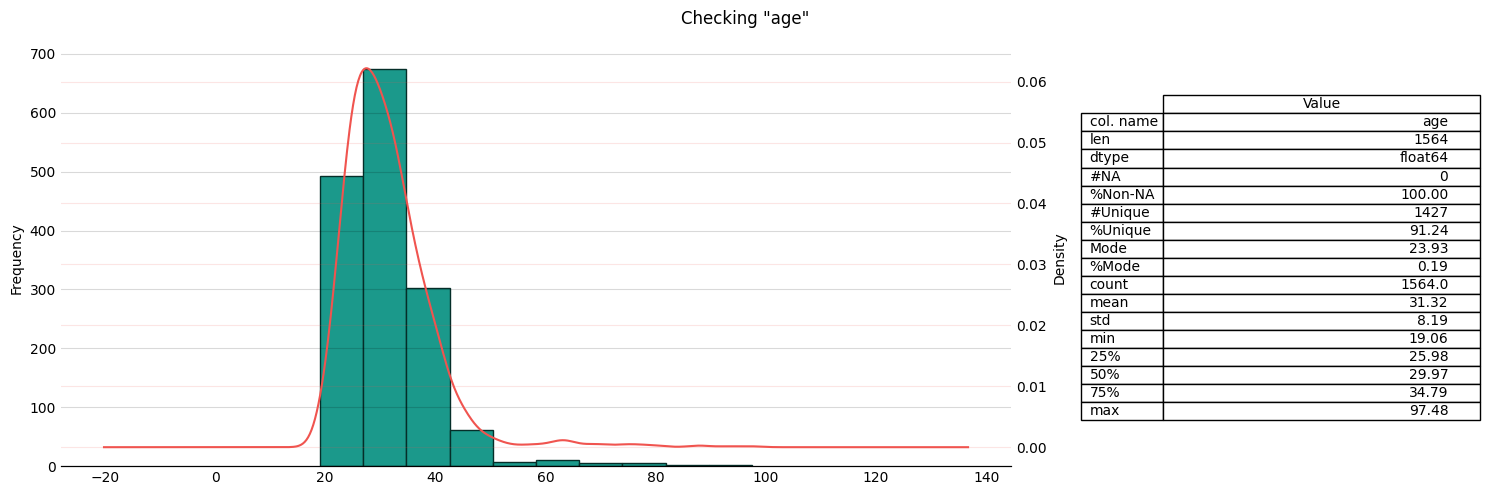

#### Checking is_alive

name | is_alive
-|-
len | 1564 
dtype | bool 
#NA | 0 
%Non-NA | 100.00 
#Unique | 2 
%Unique | 0.13 
Mode | True 
%Mode | 99.17 
count | 1564 
unique | 2 
top | True 
freq | 1551 


#### Checking height

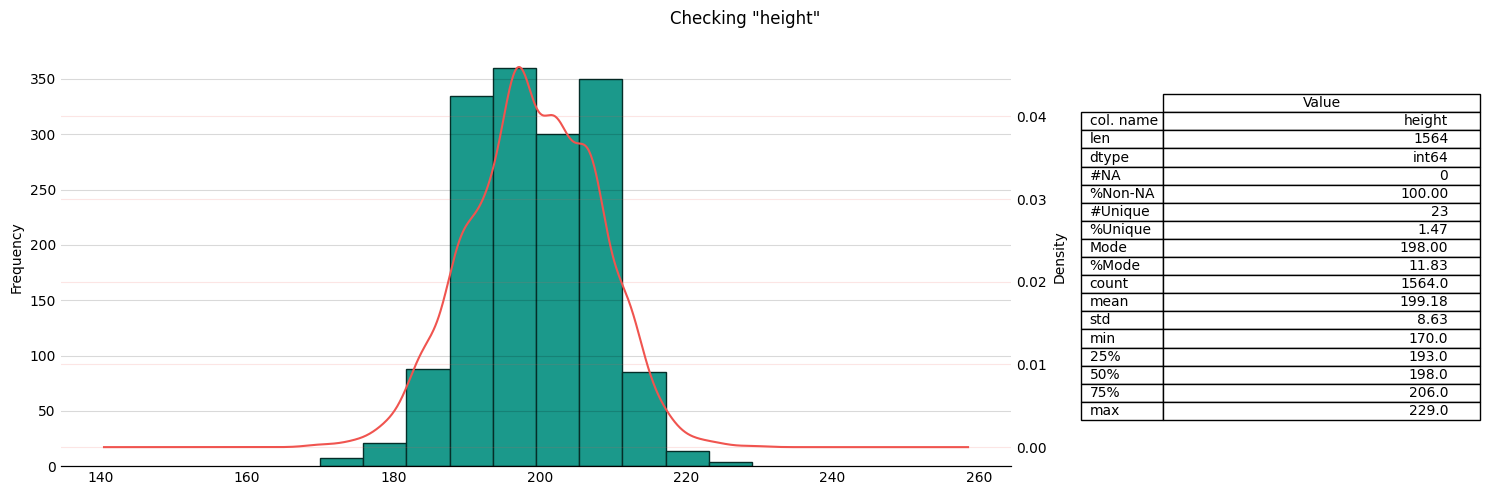

#### Checking weight

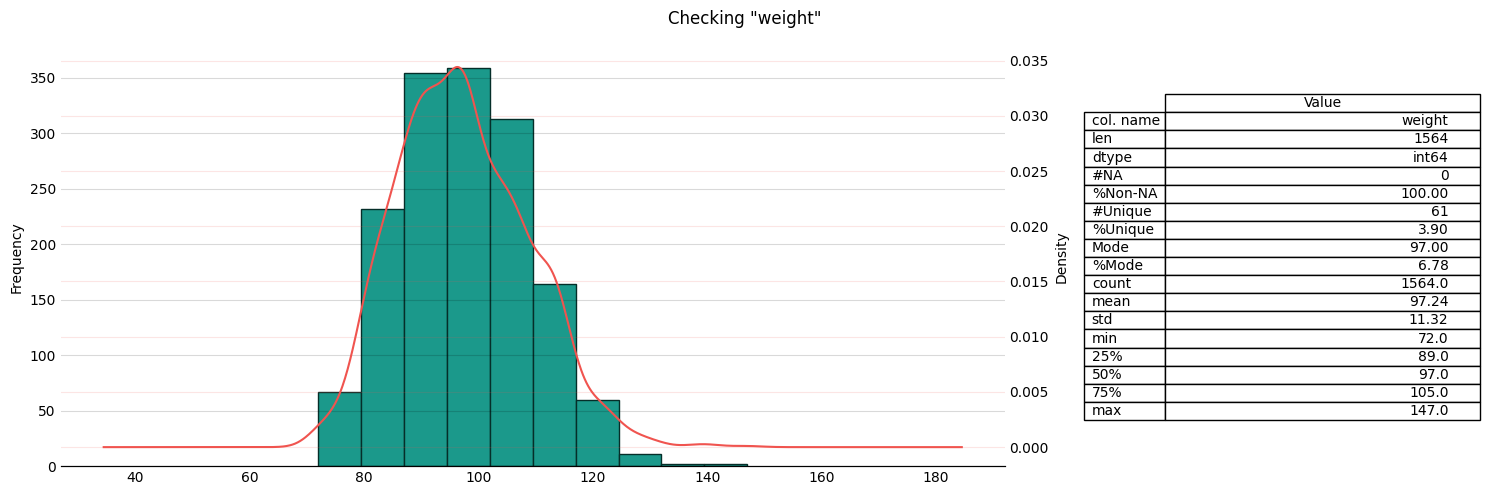

#### Checking career_length

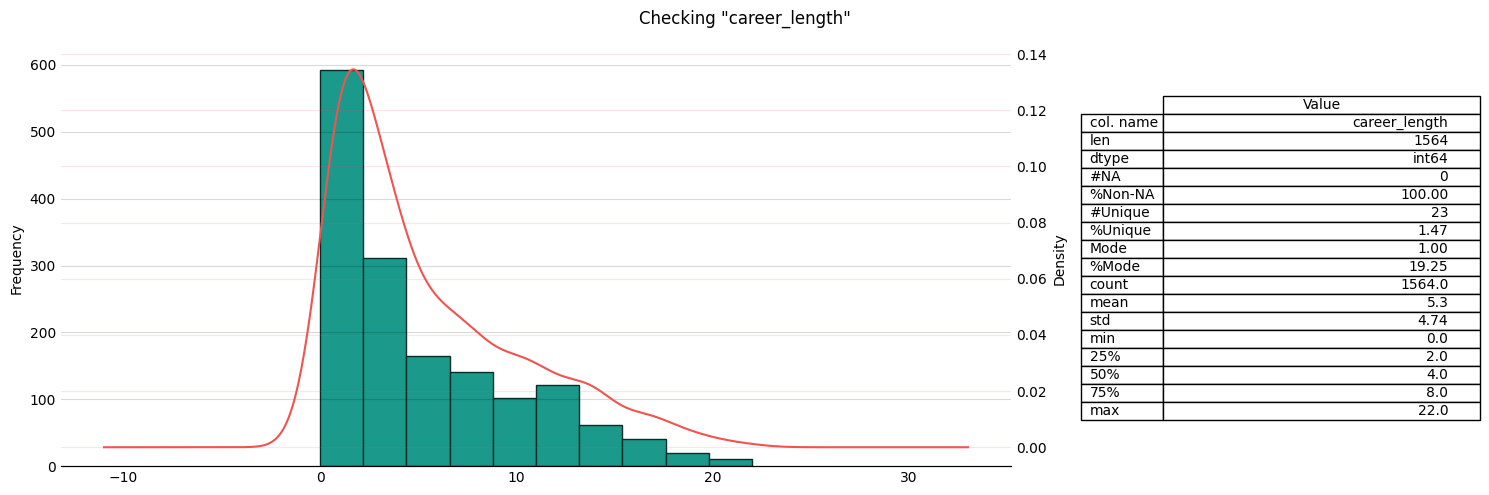

#### Checking is_active

name | is_active
-|-
len | 1564 
dtype | bool 
#NA | 0 
%Non-NA | 100.00 
#Unique | 2 
%Unique | 0.13 
Mode | True 
%Mode | 61.45 
count | 1564 
unique | 2 
top | True 
freq | 961 


#### Checking has_hall_of_fame

name | has_hall_of_fame
-|-
len | 1564 
dtype | bool 
#NA | 0 
%Non-NA | 100.00 
#Unique | 2 
%Unique | 0.13 
Mode | False 
%Mode | 97.25 
count | 1564 
unique | 2 
top | False 
freq | 1521 


#### Checking count_allstar

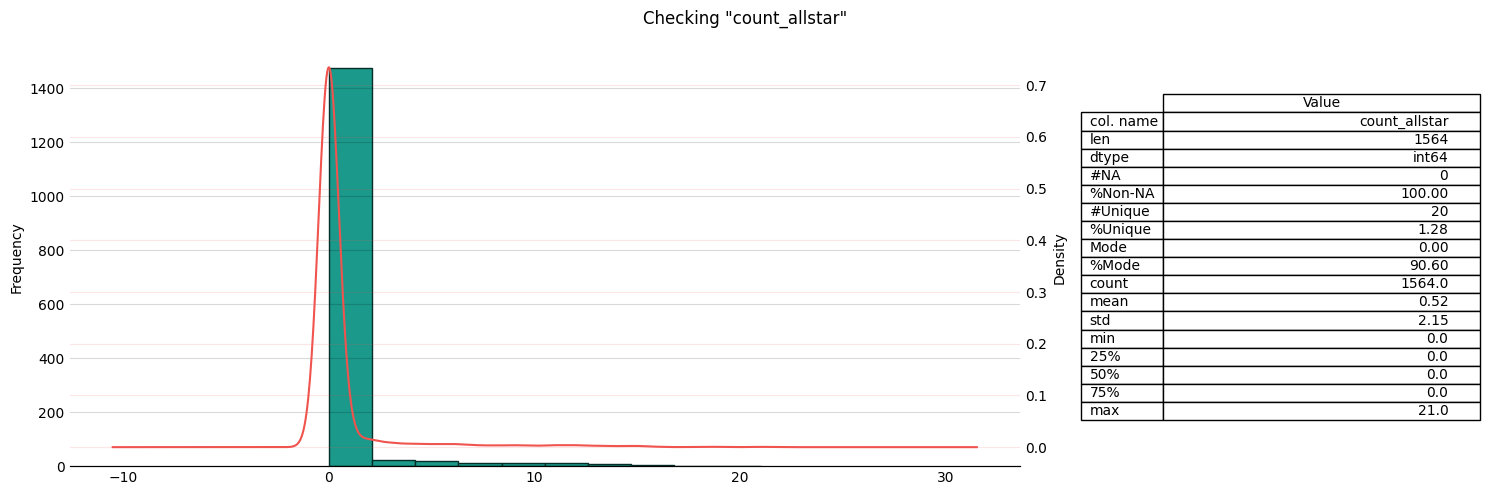

#### Checking stat_games

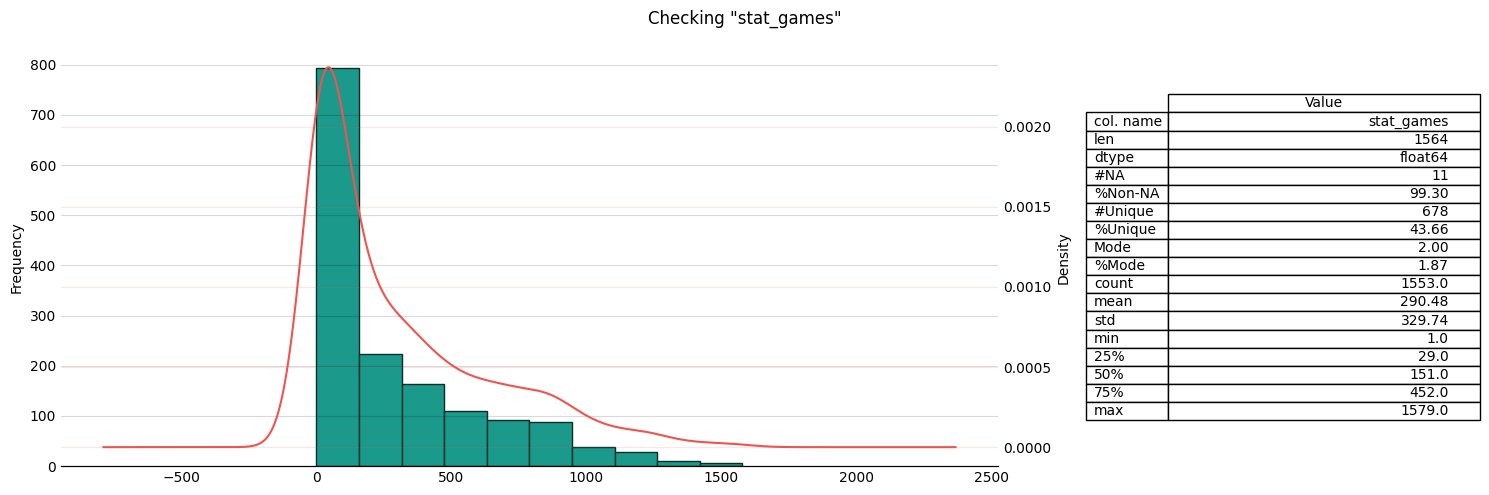

#### Checking stat_points

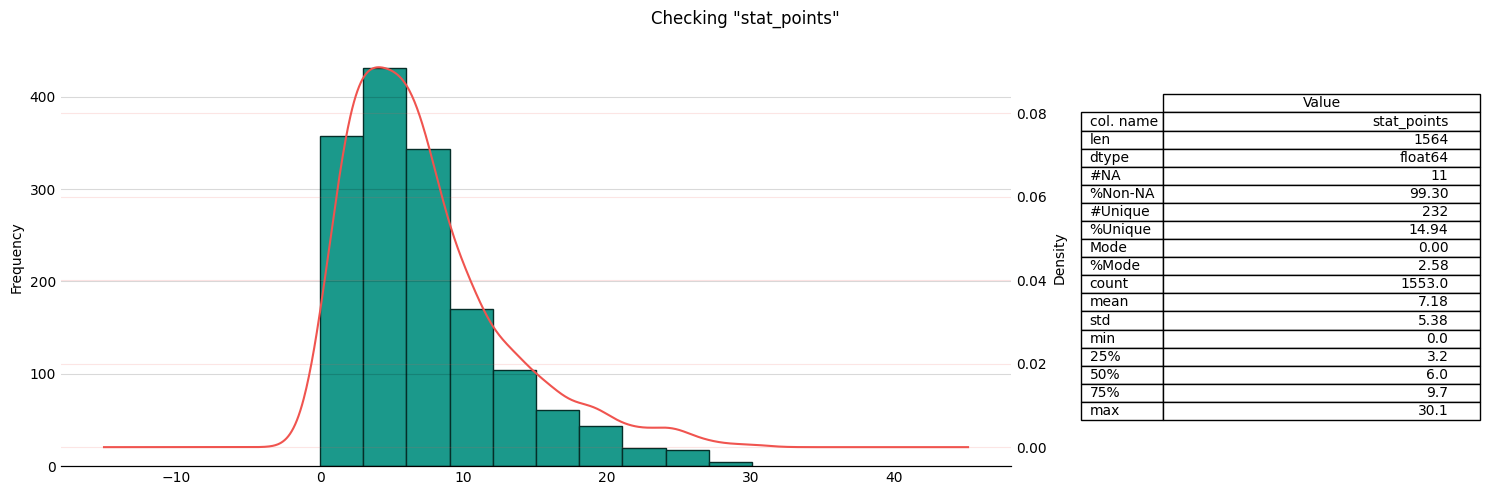

#### Checking stat_total_rebounds

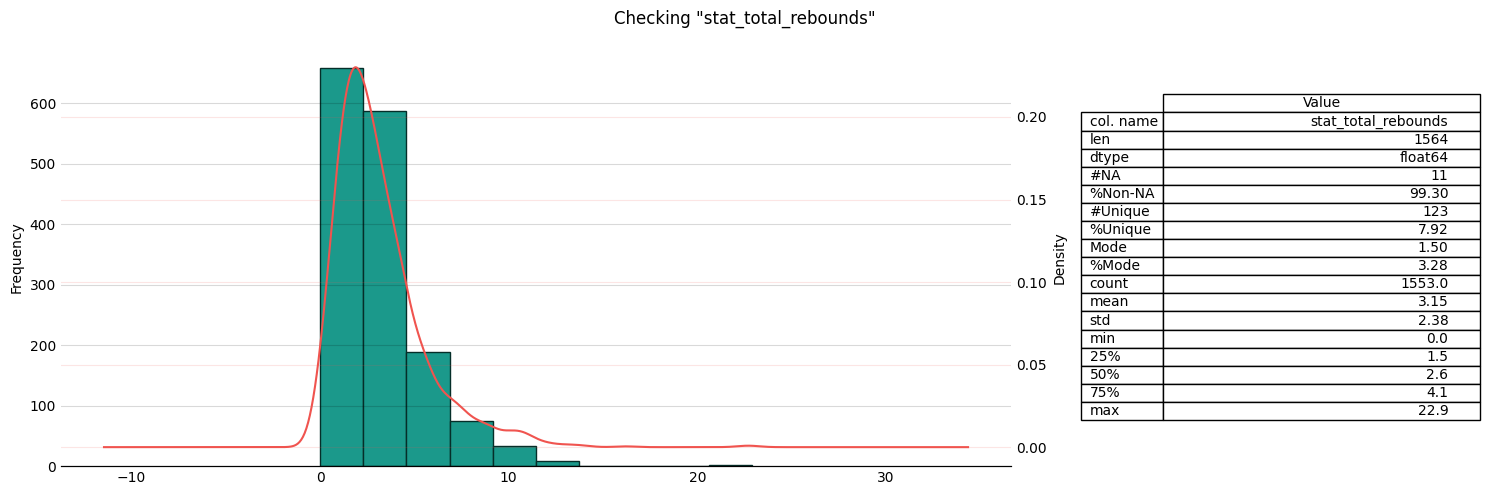

#### Checking stat_assists

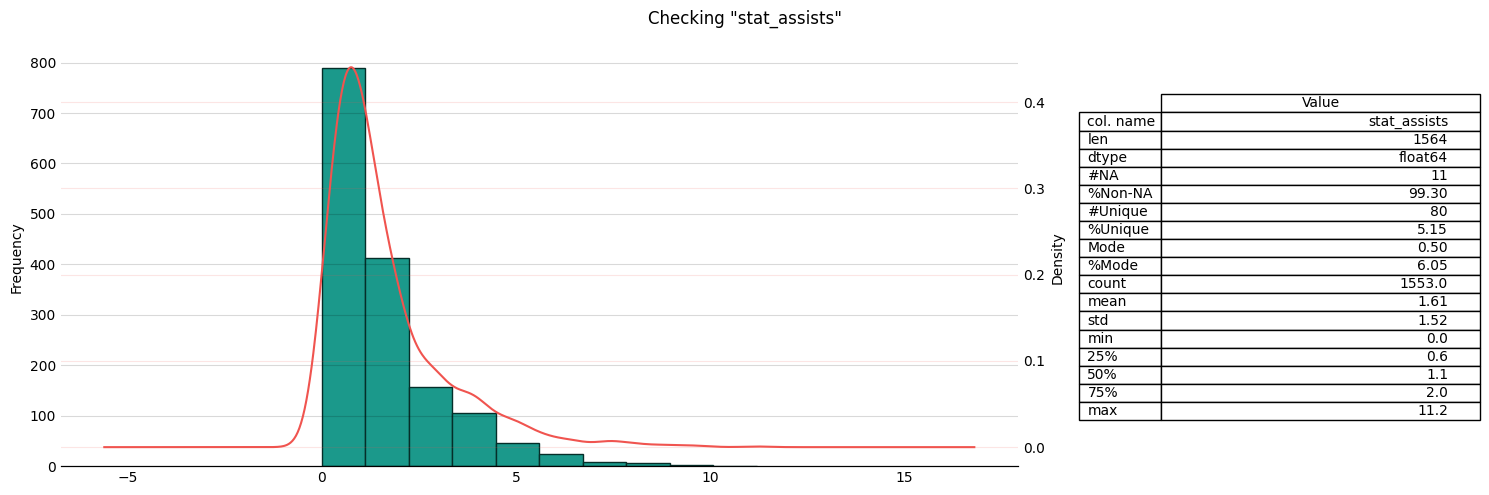

#### Checking stat_field_goal_pct

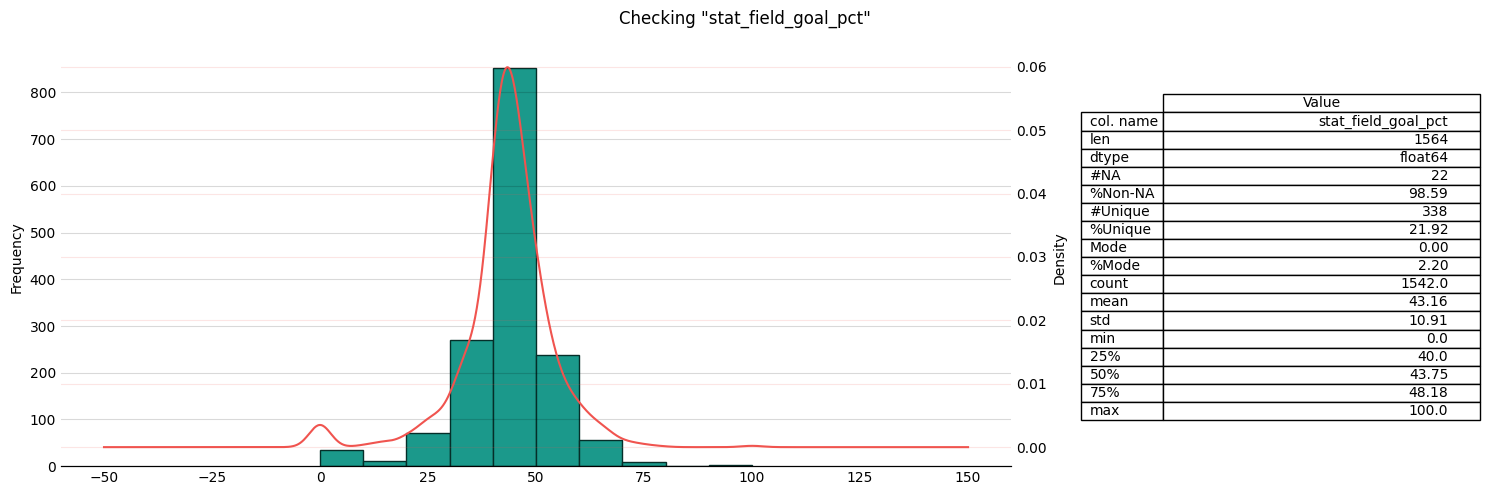

#### Checking stat_three_point_field_goal_pct

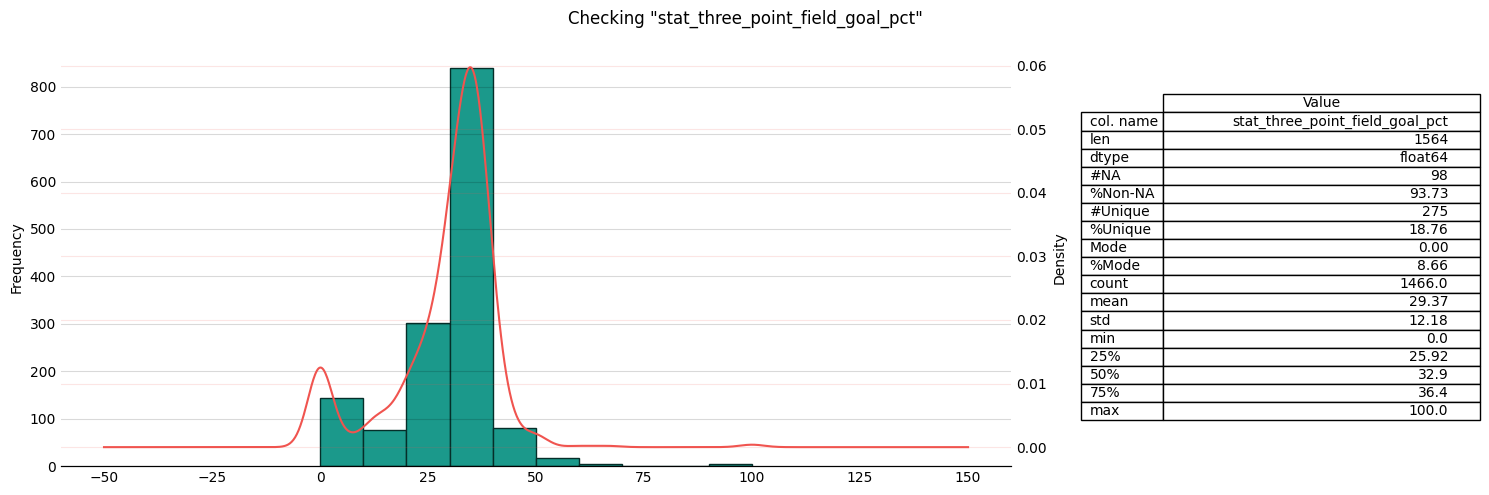

#### Checking stat_effective_field_goal_pct

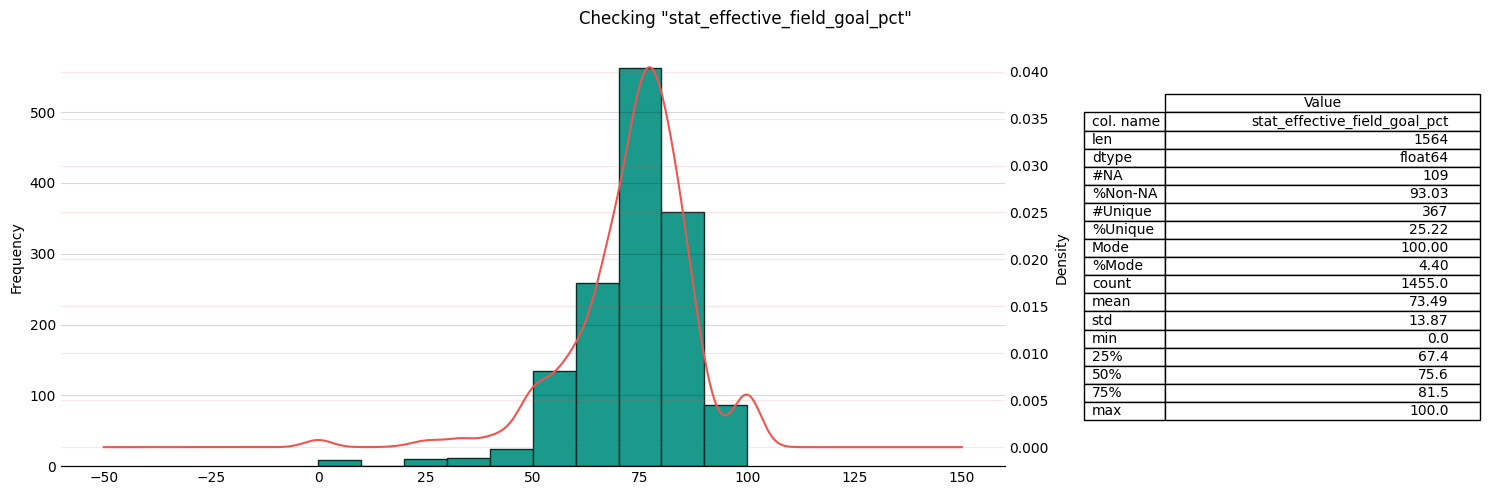

#### Checking stat_free_throw_pct

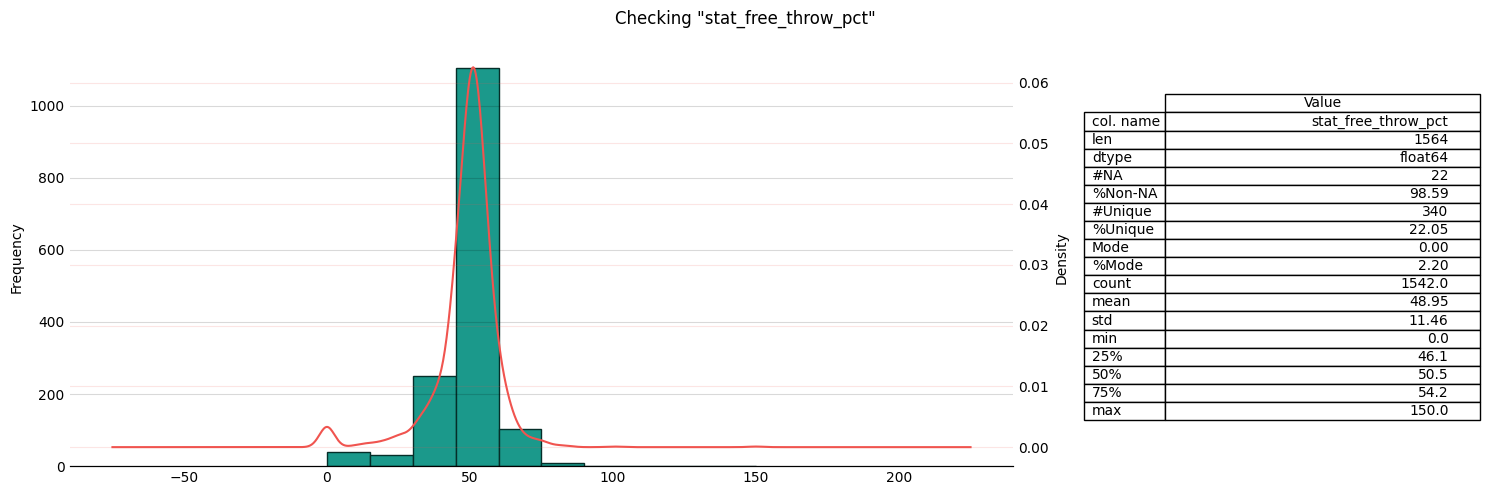

#### Checking stat_efficiency_rating

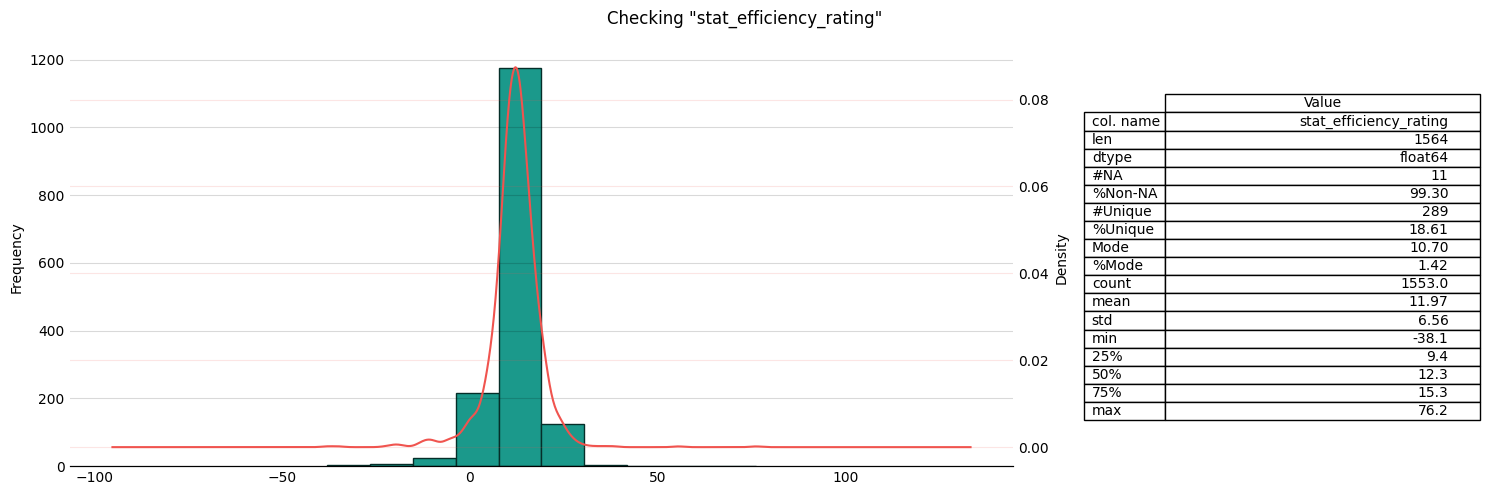

#### Checking stat_win_shares

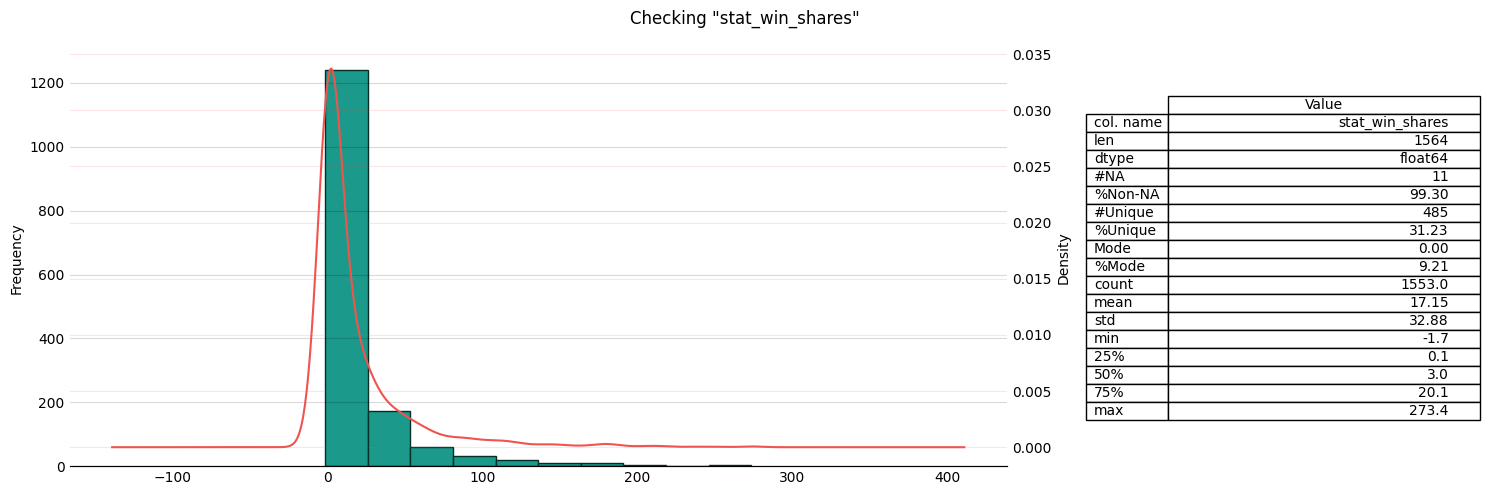

In [27]:
for column in df_players.columns:
    # print(f"checking {column}")
    check(df_players[column])

In [28]:
numeric_cols, boolean_cols, categoricals = determine_col_types(df_players)

print(f"numeric_cols: {numeric_cols}")
print(f"boolean_cols: {boolean_cols}")
print(f"categoricals: {categoricals}")

numeric_cols: ['age', 'height', 'weight', 'career_length', 'count_allstar', 'stat_games', 'stat_points', 'stat_total_rebounds', 'stat_assists', 'stat_field_goal_pct', 'stat_three_point_field_goal_pct', 'stat_effective_field_goal_pct', 'stat_free_throw_pct', 'stat_efficiency_rating', 'stat_win_shares']
boolean_cols: ['is_alive', 'is_active', 'has_hall_of_fame']
categoricals: ['id', 'name', 'pos', 'shoots']


In [29]:
frequencies = dict()

for pos in df_players[categoricals]["pos"]:
    if pos:
        if ',' in pos and ' and ' in  pos:
            pos = pos.split(',')
            pos = pos[:-2] + [pos[-1].replace(' and ', '')]
        elif ' and ' in pos:
            pos = pos.split(' and ')
        else:
            pos = [pos]
        
        for p in pos:
            if p in frequencies.keys():
                frequencies[p] = frequencies[p] + 1
            else:
                frequencies[p] = 1

data = pd.DataFrame.from_dict(frequencies, columns=['Frequency'], orient='index').sort_values(by='Frequency', ascending=False)['Frequency']

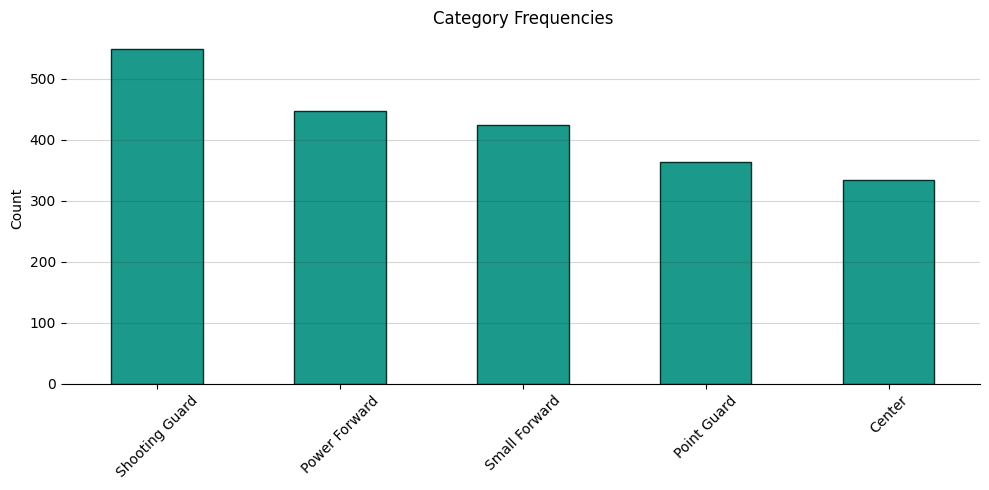

In [30]:
frequency_bars(data, min_n=2)

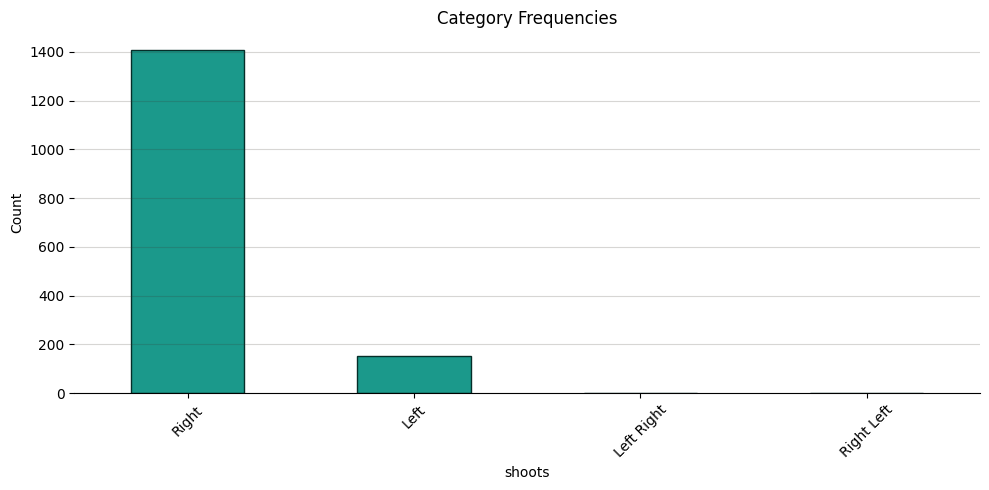

In [31]:
frequency_bars(df_players['shoots'].value_counts())

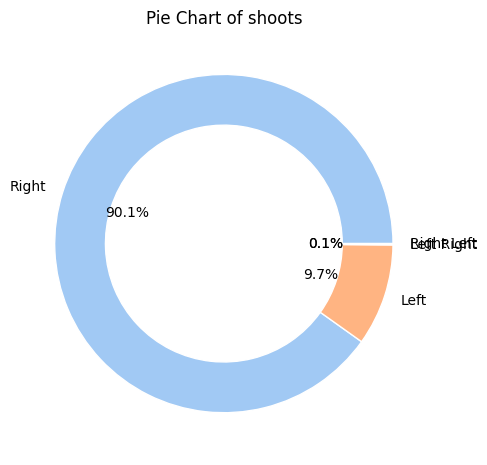

In [32]:
pie(df_players['shoots'])

In [33]:
df_players['shoots'].value_counts()

shoots
Right         1409
Left           152
Left Right       1
Right Left       1
Name: count, dtype: int64

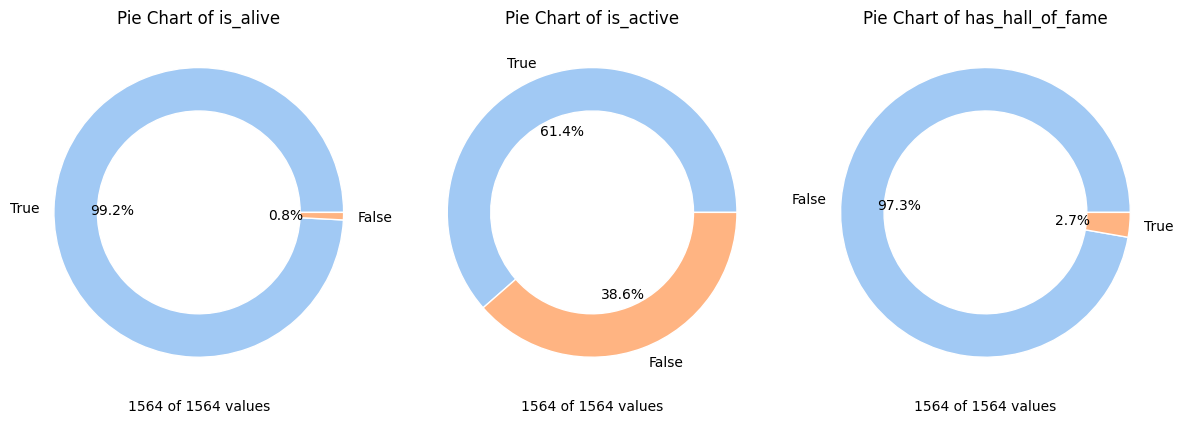

In [34]:
pies(df_players, boolean_cols)

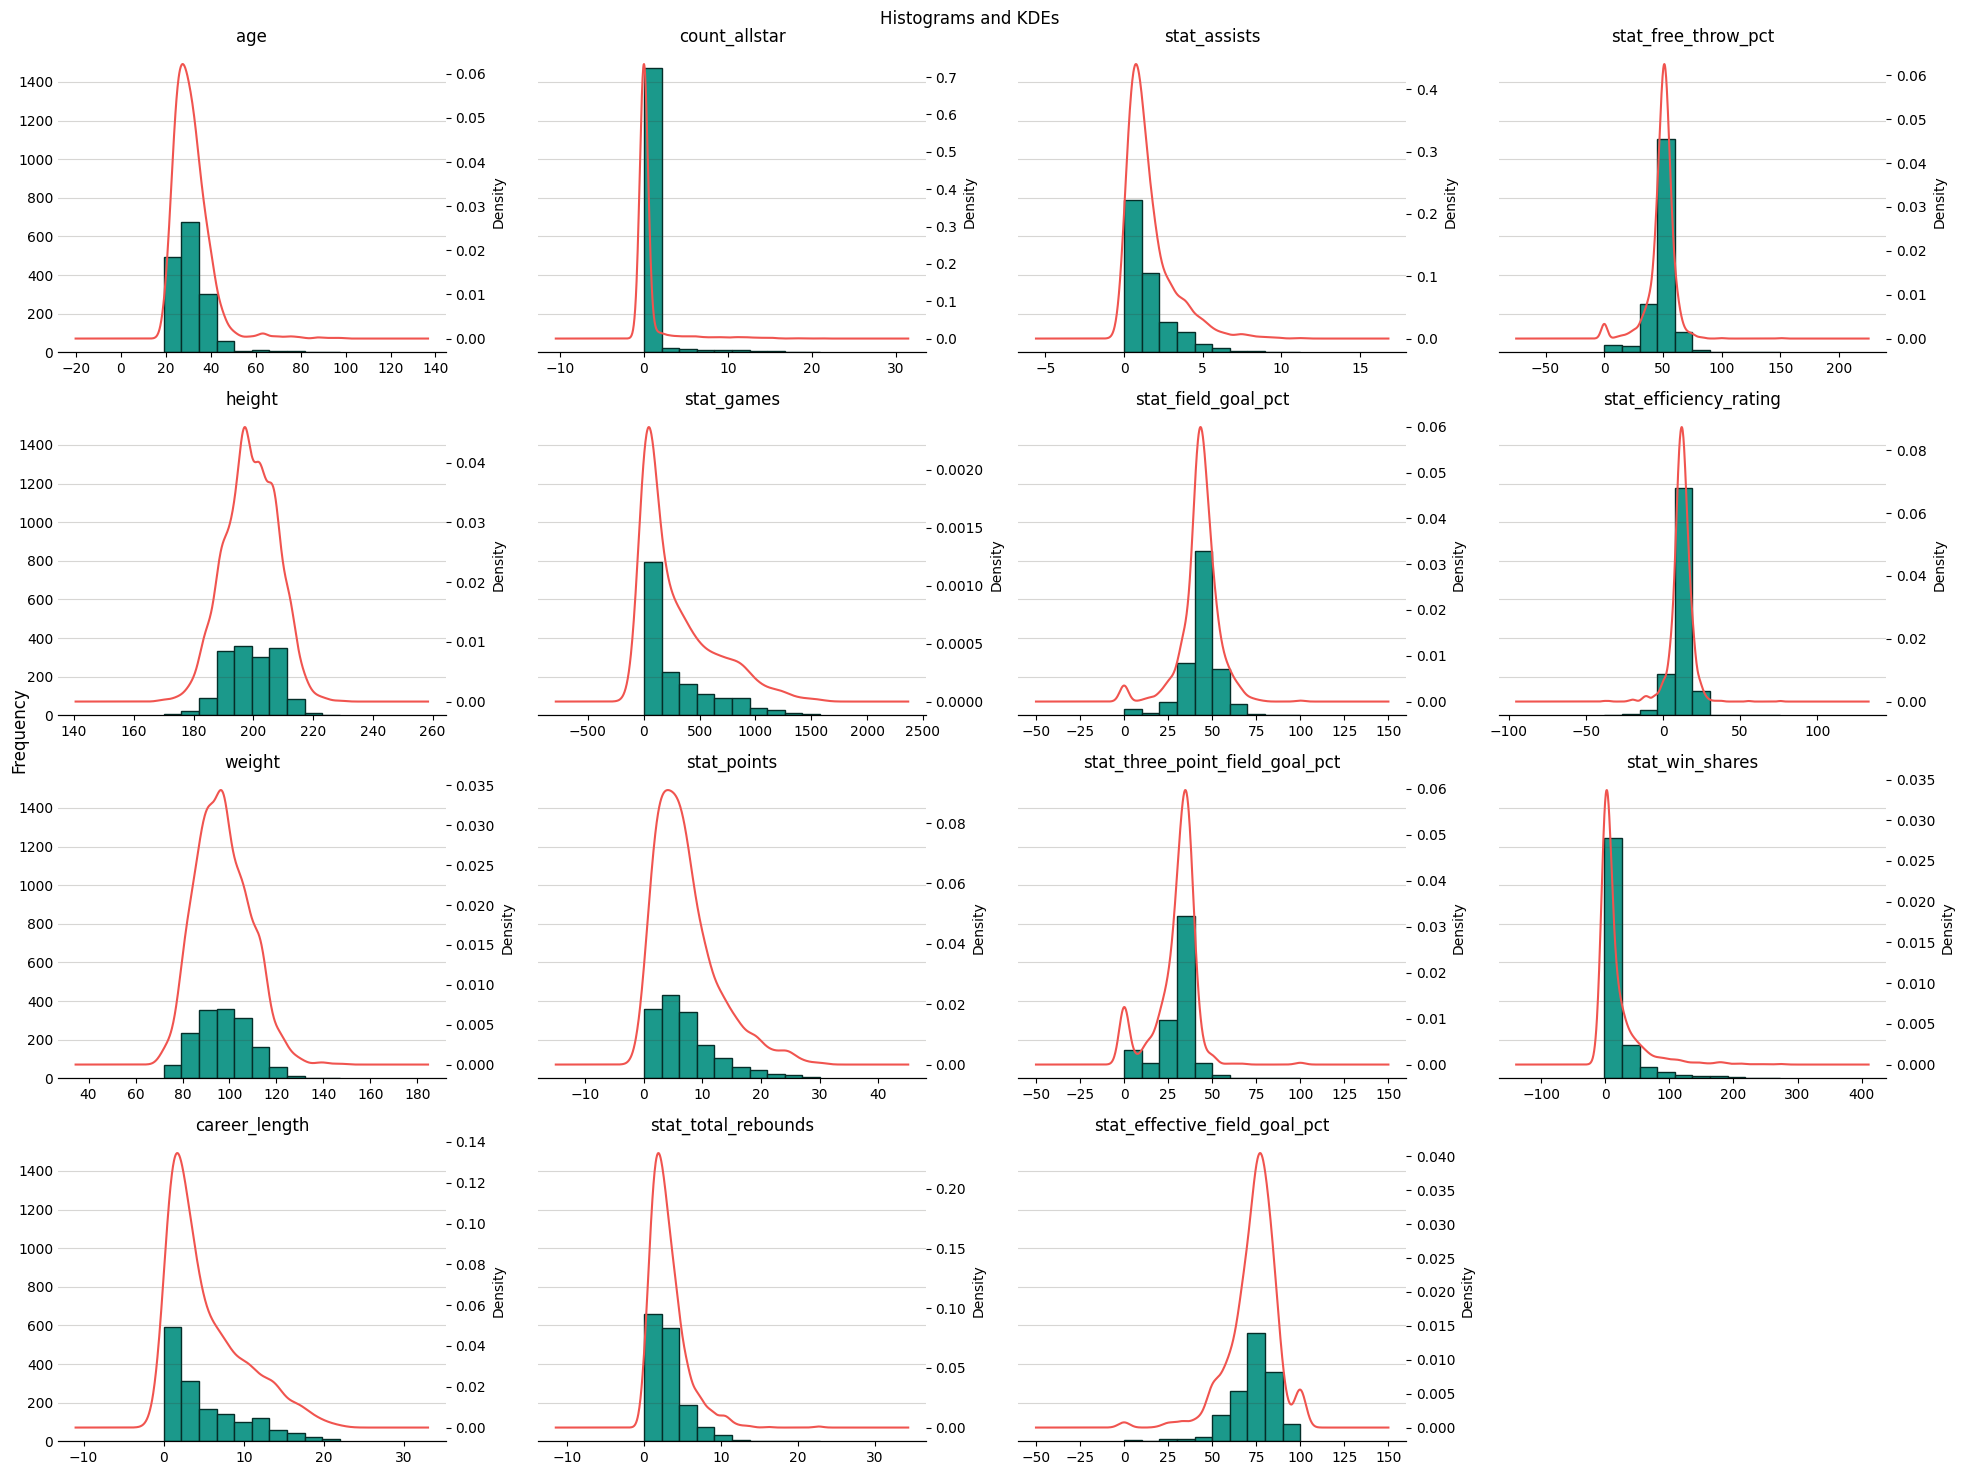

In [35]:
histograms(df_players[numeric_cols])

<div dir=rtl>

# تحلیل

</div>

<div dir=rtl>

## آمار توصیفی

</div>

<div dir=rtl>

### توزیع قد بازیکنان Michael Jordan Trophy با ۵۰ بازیکن برتر هر فصل

از فصل ۲۰۱۹-۲۰۲۰ تا پایان فصل ۲۰۲۳-۲۰۲۴
(۵ فصل)
:

</div>

In [36]:
df_mj.set_index('player_id', inplace=True)

In [37]:
df_players.set_index('id', inplace=True)

In [38]:
mj_heights = df_mj.join(df_players, how='inner')['height']

In [39]:
df_top_players.set_index('player_id', inplace=True)

In [40]:
top_players_heights = df_top_players.join(df_players, how='inner')[['height', 'season']]

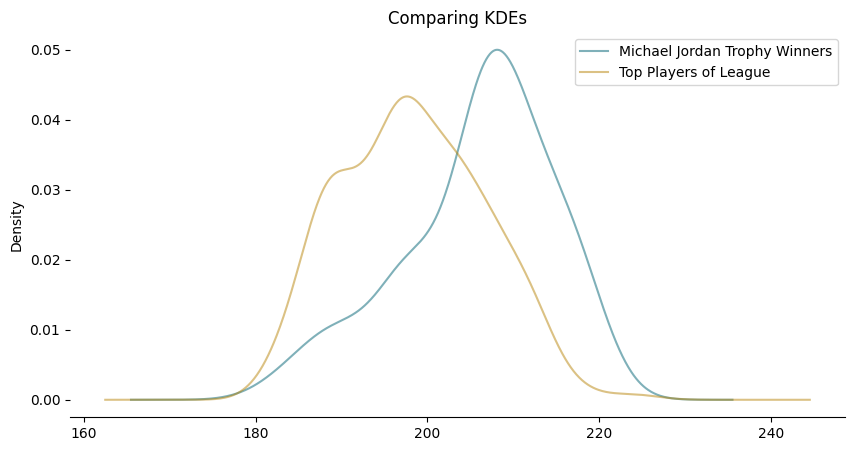

In [41]:
compare_kdes([mj_heights, top_players_heights['height']], labels=['Michael Jordan Trophy Winners', 'Top Players of League'])

<div dir=rtl>

با توجه به نمودار بالا مشخص می‌شود که قد بازیکن‌هایی که برنده جایزه مایکل جردن شده‌اند، به شکل متوسط بلندتر از بازیکن‌های برتر فصل‌های مشخص شده است. می‌توان این مورد را دقیق‌تر هم بررسی کرد:

</div>

In [42]:
print('تفاوت میانه و میانگین قد بازیکن‌هایی که برنده جایزه مایکل جردن شده‌اند با بازیکن‌های برتر فصل‌های مشخص شده به ترتیب عبارت است از')
print(f"Median diff\t{mj_heights.median() - top_players_heights['height'].median():.02f} CM")
print(f"Mean diff\t{mj_heights.mean() - top_players_heights['height'].mean():.02f} CM")

تفاوت میانه و میانگین قد بازیکن‌هایی که برنده جایزه مایکل جردن شده‌اند با بازیکن‌های برتر فصل‌های مشخص شده به ترتیب عبارت است از
Median diff	8.00 CM
Mean diff	7.46 CM


<div dir=rtl>

می‌توان فصل به فصل هم تفاوت‌ها را بررسی کرد:

</div>

In [43]:
seasons = top_players_heights['season'].unique()
seasons

array(['2019-2020', '2020-2021', '2021-2022', '2023-2024'], dtype=object)

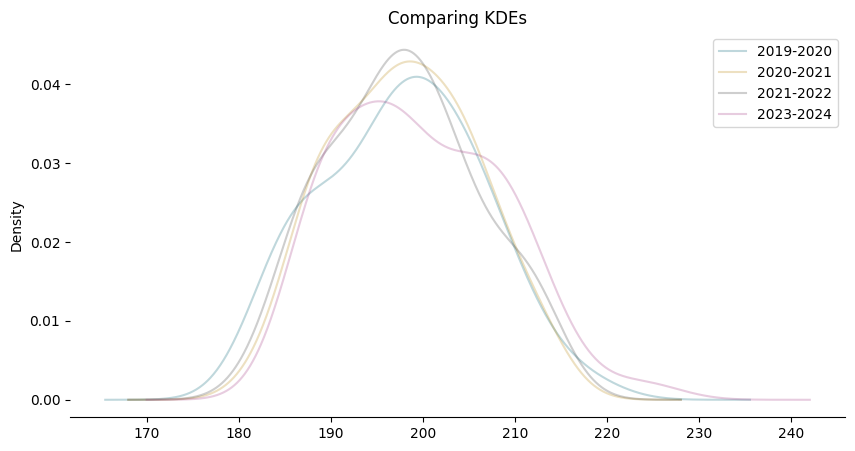

In [44]:
compare_kdes(
    data=[top_players_heights[top_players_heights['season'] == s]['height'] for s in seasons],
    labels = list(seasons))

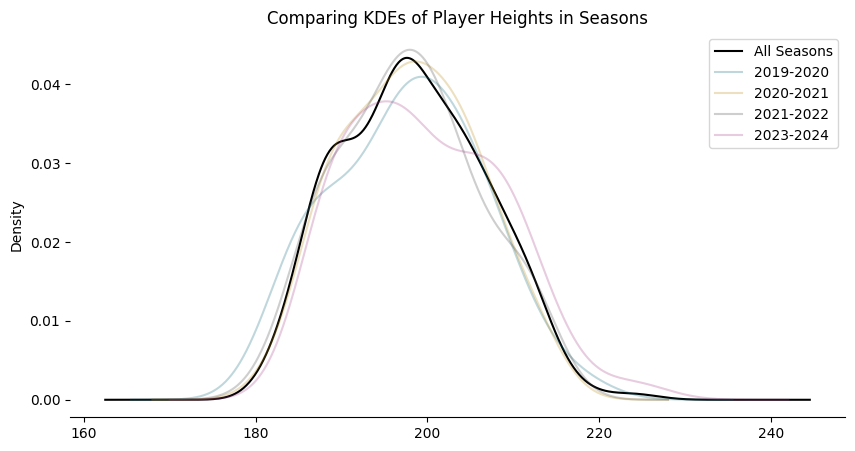

In [45]:
fig, ax  = plt.subplots(figsize=(10,5))
top_players_heights['height'].plot.kde(ax=ax, color="#000000", alpha=1, label="All Seasons")
compare_kdes(
    data=[top_players_heights[top_players_heights['season'] == s]['height'] for s in seasons],
    labels = list(seasons),
    ax=ax)
ax.set_title('Comparing KDEs of Player Heights in Seasons');

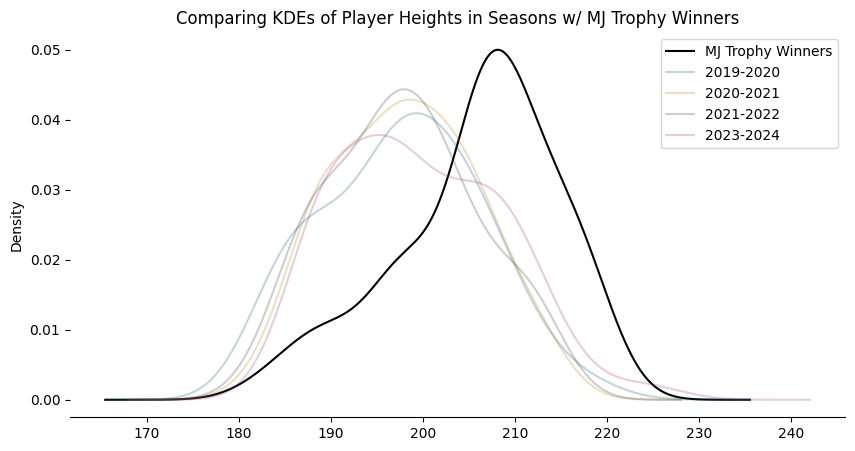

In [46]:
fig, ax  = plt.subplots(figsize=(10,5))
mj_heights.plot.kde(ax=ax, color="#000000", alpha=1, label="MJ Trophy Winners")
compare_kdes(
    data=[top_players_heights[top_players_heights['season'] == s]['height'] for s in seasons],
    labels = list(seasons),
    ax=ax)
ax.set_title('Comparing KDEs of Player Heights in Seasons w/ MJ Trophy Winners');

<div dir=rtl>

### توزیع تجربه و قد افراد فعال در افراد تیم‌های قهرمان دو فصل آخر و ۱۵ بازیکن برتر آن فصل

</div>

In [47]:
# champion team season 2022-23

conn = sqlite3.connect('../db/main.db')

champ2022_23 = pd.read_sql('''
                 SELECT c.season, c.champion, p.id, p.name, p.career_length, p.height
                 FROM champions c 
                 JOIN roster_data rd on c.Champion = rd.team_name 
                 JOIN players p on rd.player_id = p.id
                 WHERE c.season = "2022-23" AND rd.season = "2022-23" AND p.is_active=True ;
                 ''', conn)
# champ2022_23

In [48]:
# champion team season 2023-24

conn = sqlite3.connect('../db/main.db')

champ2023_24 = pd.read_sql('''
                 SELECT c.season, c.champion, p.id, p.name, p.career_length, p.height
                 FROM champions c 
                 JOIN roster_data rd on c.Champion = rd.team_name 
                 JOIN players p on rd.player_id = p.id
                 WHERE c.season = "2023-24" AND rd.season = "2023-24" AND p.is_active=True;
                 ''', conn)
# champ2023_24

In [49]:
# champion team season 2022-23 & 2023-24

champ2022_24 = pd.concat([champ2022_23, champ2023_24], ignore_index=True)
# champ2022_24

In [50]:
# top 15 players for season 2022-23

conn = sqlite3.connect('../db/main.db')

top15_2022_23 = pd.read_sql('''
                           SELECT pe.player_id, p.name, pe.season, pe.rank, pe.points, p.career_length, p.height 
                           FROM player_evaluations pe 
                           JOIN players p on pe.player_id = p.id 
                           WHERE season = "2022-2023" and rank <= 15;
                           ''', conn)
# top15_2022_23

In [51]:
# top 15 players for season 2023-24

conn = sqlite3.connect('../db/main.db')

top15_2023_24 = pd.read_sql('''
                           SELECT pe.player_id, p.name, pe.season, pe.rank, pe.points, p.career_length, p.height 
                           FROM player_evaluations pe 
                           JOIN players p on pe.player_id = p.id 
                           WHERE season = "2023-2024" and rank <= 15;
                           ''', conn)
# top15_2023_24

In [52]:
# top 15 players for season 2022-23 & 2023-24

top15_2022_24 = pd.concat([top15_2022_23, top15_2023_24], ignore_index=True)
# top15_2022_24

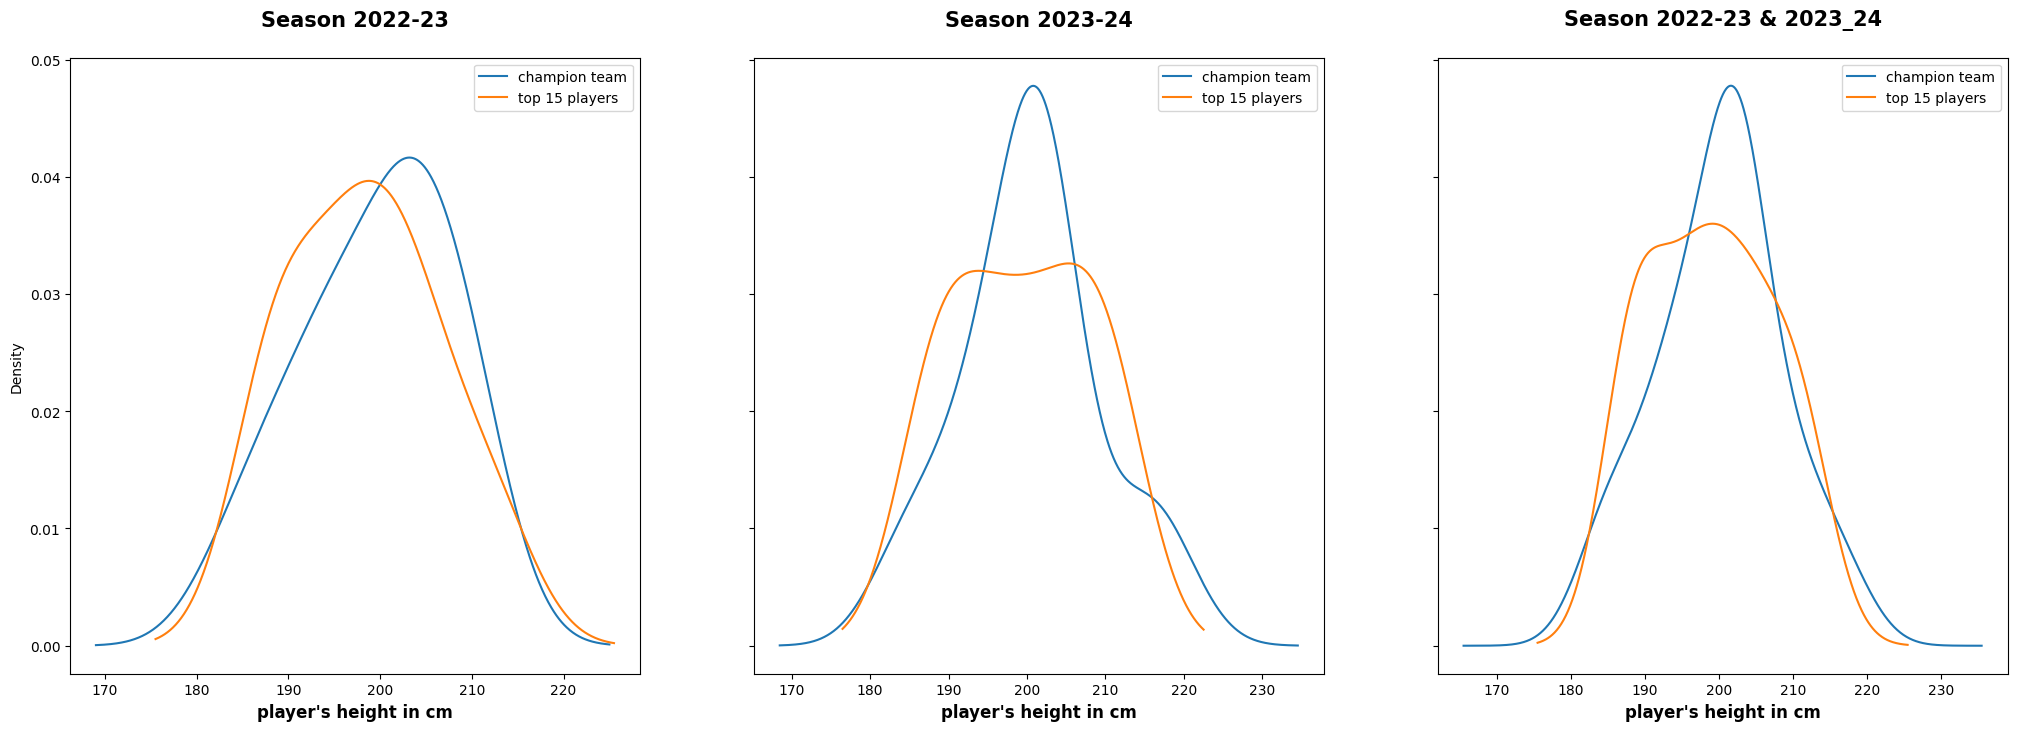

In [53]:
fig, axes = plt.subplots(1, 3, figsize = (25,8), sharey=True)

champ2022_23['height'].plot(kind='kde', ax=axes[0], label='champion team')
top15_2022_23['height'].plot(kind='kde',ax=axes[0], label='top 15 players')

champ2023_24['height'].plot(kind='kde', ax=axes[1], label='champion team')
top15_2023_24['height'].plot(kind='kde',ax=axes[1], label='top 15 players')

champ2022_24['height'].plot(kind='kde', ax=axes[2], label='champion team')
top15_2022_24['height'].plot(kind='kde',ax=axes[2], label='top 15 players')



axes[0].set_title('Season 2022-23\n', fontweight='bold', fontsize=15)
axes[0].set_xlabel('player\'s height in cm', fontweight='bold', fontsize= 12)

axes[1].set_title('Season 2023-24\n', fontweight='bold', fontsize=15)
axes[1].set_xlabel('player\'s height in cm', fontweight='bold', fontsize= 12)
axes[2].set_title('Season 2022-23 & 2023_24\n', fontweight='bold', fontsize=15)
axes[2].set_xlabel('player\'s height in cm', fontweight='bold', fontsize= 12)

for ax in axes:
    ax.legend()



<div dir=rtl>

با توجه به نمودارهای بدست آمده، به نظر می‌رسد که قد بازیکن‌های تیم برتر و ۱۵ بازیکن برتر هر فصل تفاوت‌های اندک اما مشخصی دارند.

</div>

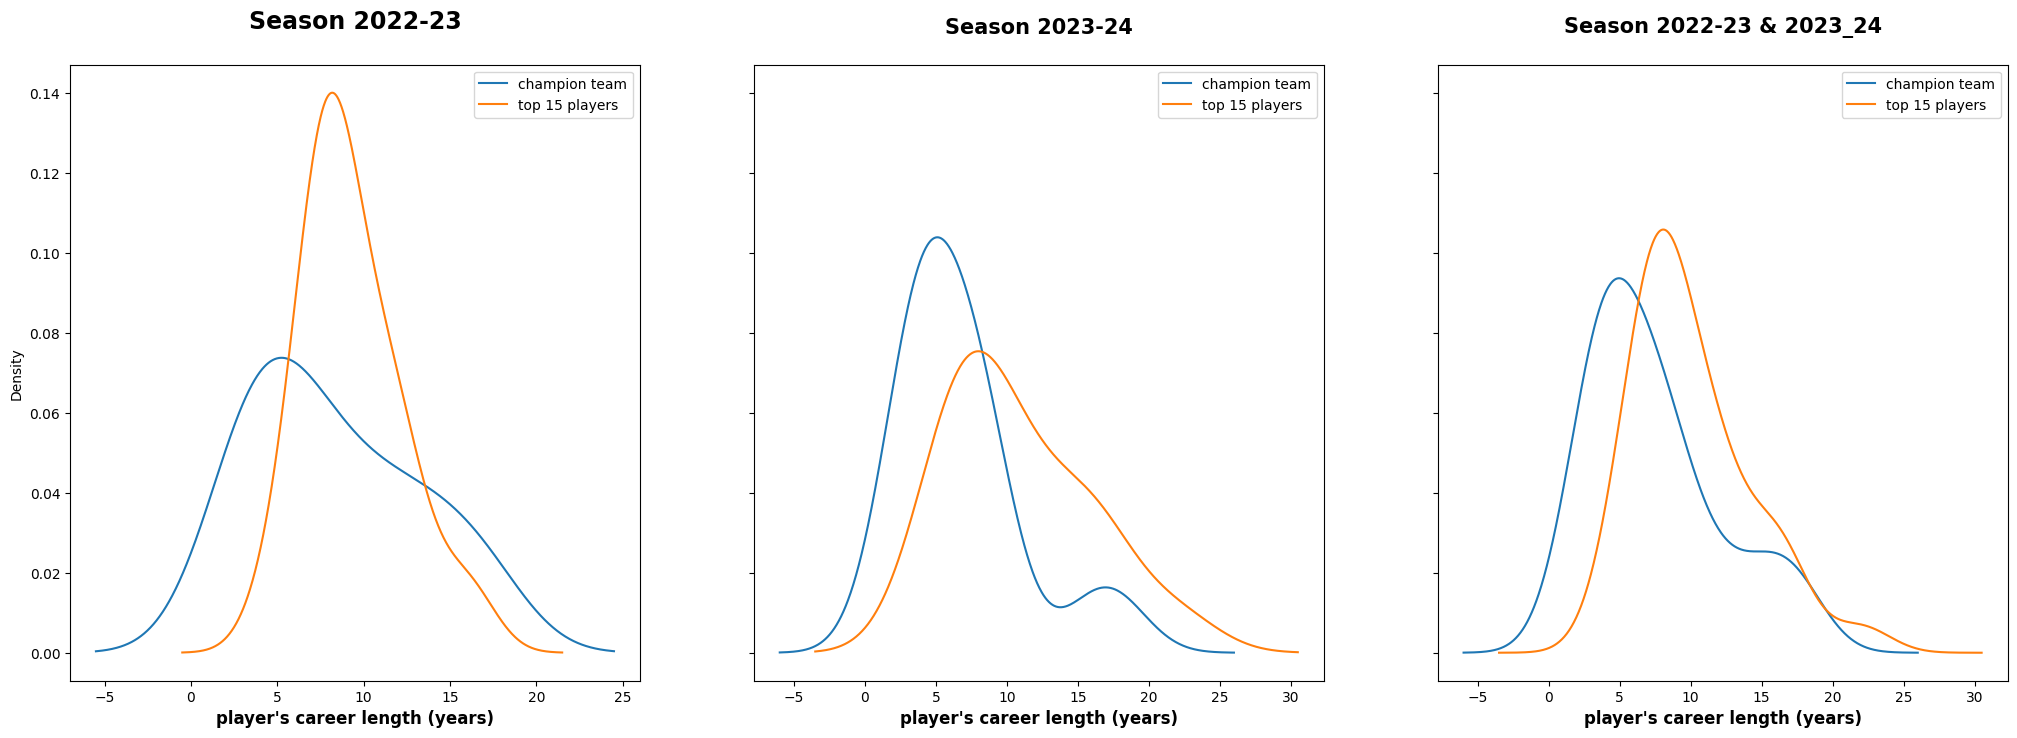

In [54]:

fig, axes = plt.subplots(1, 3, figsize = (25,8), sharey=True)

champ2022_23['career_length'].plot(kind='kde', ax=axes[0], label='champion team')
top15_2022_23['career_length'].plot(kind='kde',ax=axes[0], label='top 15 players')

champ2023_24['career_length'].plot(kind='kde', ax=axes[1], label='champion team')
top15_2023_24['career_length'].plot(kind='kde',ax=axes[1], label='top 15 players')

champ2022_24['career_length'].plot(kind='kde', ax=axes[2], label='champion team')
top15_2022_24['career_length'].plot(kind='kde',ax=axes[2], label='top 15 players')



axes[0].set_title('Season 2022-23\n', fontweight='bold', fontsize=17)
axes[0].set_xlabel('player\'s career length (years)', fontweight='bold', fontsize= 12)
axes[1].set_title('Season 2023-24\n', fontweight='bold', fontsize=15)
axes[1].set_xlabel('player\'s career length (years)', fontweight='bold', fontsize= 12)
axes[2].set_title('Season 2022-23 & 2023_24\n', fontweight='bold', fontsize=15)
axes[2].set_xlabel('player\'s career length (years)', fontweight='bold', fontsize= 12)

for ax in axes:
    ax.legend()


<div dir=rtl>

با توجه به نمودارهای بدست آمده، به نظر می‌رسد که تجربه بازی ۱۵ بازیکن برتر هر فصل به شکل مشخصی به طور میانگین بیشتر از تجربه بازیکن‌های تیم برتر آن فصل است.

</div>

<div dir=rtl>

### لیست بازیکن‌های پیشنهادی برای خرید


</div>

In [55]:
#connect db

conn = sqlite3.connect('../db/main.db')
c=conn.cursor()

#query
c.execute("""select
    p.id,
    a.award_type,
    p.name,
    p.age,
    p.height,
    p.weight,
    a.season,
    p.pos,
    a.points_per_game,
    a.assists_per_game,
    a.win_shares,
    s.salary,
    a.pct_threeP_field_goals
FROM players p
join awards a on
p.id=a.player_id
join salaries s on
s.player_id=a.player_id and s.season=a.season
WHERE p.pos LIKE '%Point Guard%' and s.season > 2018 ;
""")

result=c.fetchall()
print(result)

[('s/smartma01', 'DPOY', 'Marcus Smart', 31.863013698630137, 190, 99, '2021-22', 'Point Guard and Shooting Guard', 12.1, 5.9, 5.6, 13839285, 0.331), ('a/antetgi01', 'DPOY', 'Giannis Antetokounmpo', 31.10958904109589, 211, 110, '2019-20', 'Power Forward, Small Forward, Point Guard, and Shooting Guard', 29.5, 5.6, 11.1, 25842697, 0.304), ('a/antetgi01', 'MVP', 'Giannis Antetokounmpo', 31.10958904109589, 211, 110, '2018-19', 'Power Forward, Small Forward, Point Guard, and Shooting Guard', 27.7, 5.9, 14.4, 24157304, 0.256), ('a/antetgi01', 'MVP', 'Giannis Antetokounmpo', 31.10958904109589, 211, 110, '2019-20', 'Power Forward, Small Forward, Point Guard, and Shooting Guard', 29.5, 5.6, 11.1, 25842697, 0.304), ('g/gilgesh01', 'MVP', 'Shai Gilgeous-Alexander', 27.50958904109589, 198, 88, '2024-25', 'Point Guard and Shooting Guard', 32.7, 6.4, 16.7, 35859950, 0.375)]


In [56]:
column_names = [
    'id', 'award_type', 'name', 'age', 'height', 'weight',
    'season', 'pos', 'points_per_game', 'assists_per_game',
    'win_shares', 'salary', 'pct_threeP_field_goals'
]

df = pd.DataFrame(result, columns=column_names)

In [57]:
cols_to_numeric = [
    'age','points_per_game', 'assists_per_game',
    'win_shares', 'salary', 'pct_threeP_field_goals' , 'height' , 'weight'
]


for col in cols_to_numeric:

  df[col] = pd.to_numeric(df[col])

df['final_score'] = df['assists_per_game'] *0.65 + df['win_shares'] *0.1 +  df['age'] *0.1 + df['height'] *0.1 + df['salary']*0.0001


print(df[['id','name','award_type','age', 'height','weight',  'season', 'pos', 'salary', 'win_shares', 'assists_per_game','points_per_game',"final_score"]].head())

            id                     name award_type        age  height  weight  \
0  s/smartma01             Marcus Smart       DPOY  31.863014     190      99   
1  a/antetgi01    Giannis Antetokounmpo       DPOY  31.109589     211     110   
2  a/antetgi01    Giannis Antetokounmpo        MVP  31.109589     211     110   
3  a/antetgi01    Giannis Antetokounmpo        MVP  31.109589     211     110   
4  g/gilgesh01  Shai Gilgeous-Alexander        MVP  27.509589     198      88   

    season                                                pos    salary  \
0  2021-22                     Point Guard and Shooting Guard  13839285   
1  2019-20  Power Forward, Small Forward, Point Guard, and...  25842697   
2  2018-19  Power Forward, Small Forward, Point Guard, and...  24157304   
3  2019-20  Power Forward, Small Forward, Point Guard, and...  25842697   
4  2024-25                     Point Guard and Shooting Guard  35859950   

   win_shares  assists_per_game  points_per_game  final_score 

                       age    height  points_per_game  assists_per_game  \
age               1.000000  0.173041        -0.600578         -0.822568   
height            0.173041  1.000000         0.678544         -0.563894   
points_per_game  -0.600578  0.678544         1.000000          0.120180   
assists_per_game -0.822568 -0.563894         0.120180          1.000000   
win_shares       -0.773743  0.403665         0.869263          0.523270   
salary           -0.874582  0.318295         0.912015          0.482369   
final_score      -0.874066  0.319378         0.912476          0.481642   

                  win_shares    salary  final_score  
age                -0.773743 -0.874582    -0.874066  
height              0.403665  0.318295     0.319378  
points_per_game     0.869263  0.912015     0.912476  
assists_per_game    0.523270  0.482369     0.481642  
win_shares          1.000000  0.908648     0.908911  
salary              0.908648  1.000000     0.999999  
final_score         0

Text(0.5, 1.0, 'correlatin players')

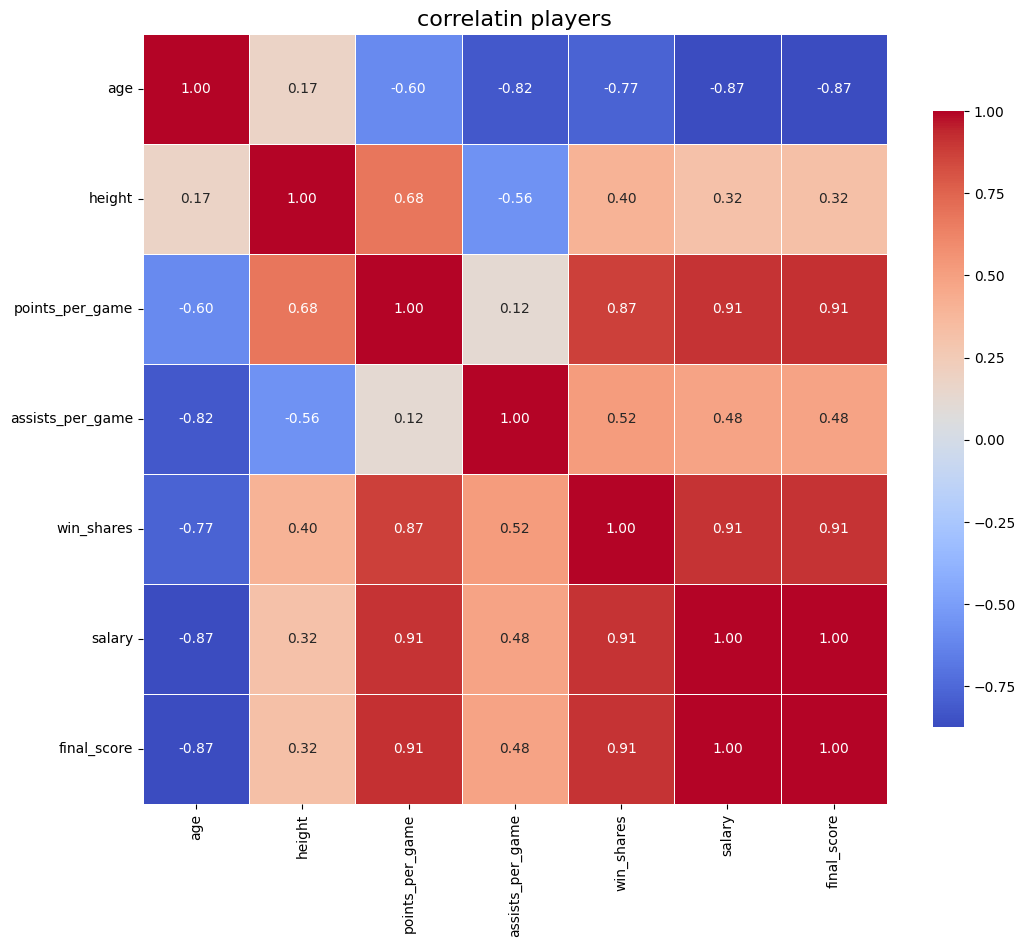

In [58]:
correlation_cols = [
    'age',
    'height',
    'points_per_game',
    'assists_per_game',
    'win_shares',
    'salary',
    'final_score'
]

available_cols = [col for col in correlation_cols if col in df.columns]
correlation_matrix = df[available_cols].corr()
print(correlation_matrix)

plt.figure(figsize=(12, 10))
sns.heatmap(
        correlation_matrix,
        annot=True,
        cmap='coolwarm',
        fmt=".2f",
        linewidths=.5,
        cbar_kws={'shrink': .8}
    )
plt.title('correlatin players', fontsize=16)

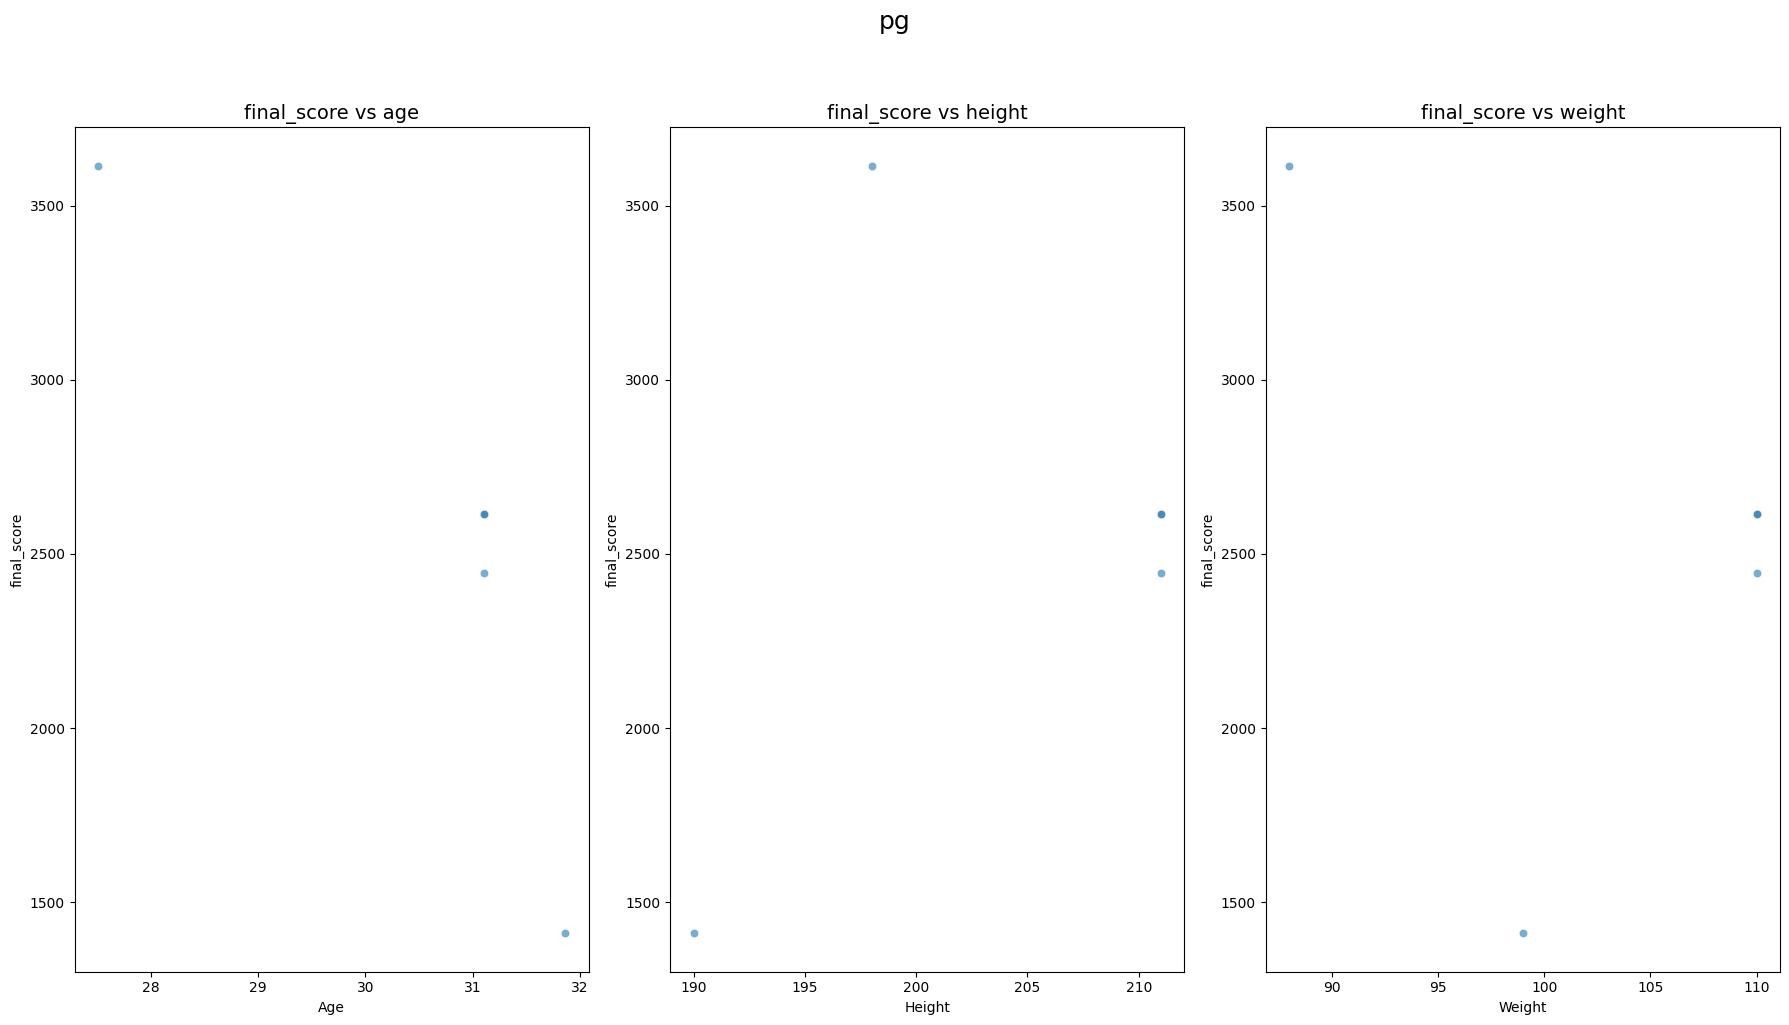

In [59]:
efficiency_metrics = [
    'final_score',
]
physical_features = ['age', 'height', 'weight']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, metric in enumerate(efficiency_metrics):
    for j, feature in enumerate(physical_features):
        ax_index = i * len(physical_features) + j
        sns.scatterplot(
            x=feature,
            y=metric,
            data=df,
            ax=axes[ax_index],
            alpha=0.6
        )
        axes[ax_index].set_title(f'{metric} vs {feature}', fontsize=14)
        axes[ax_index].set_xlabel(feature.capitalize())
        axes[ax_index].set_ylabel(metric)
plt.suptitle('pg', fontsize=18, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98])

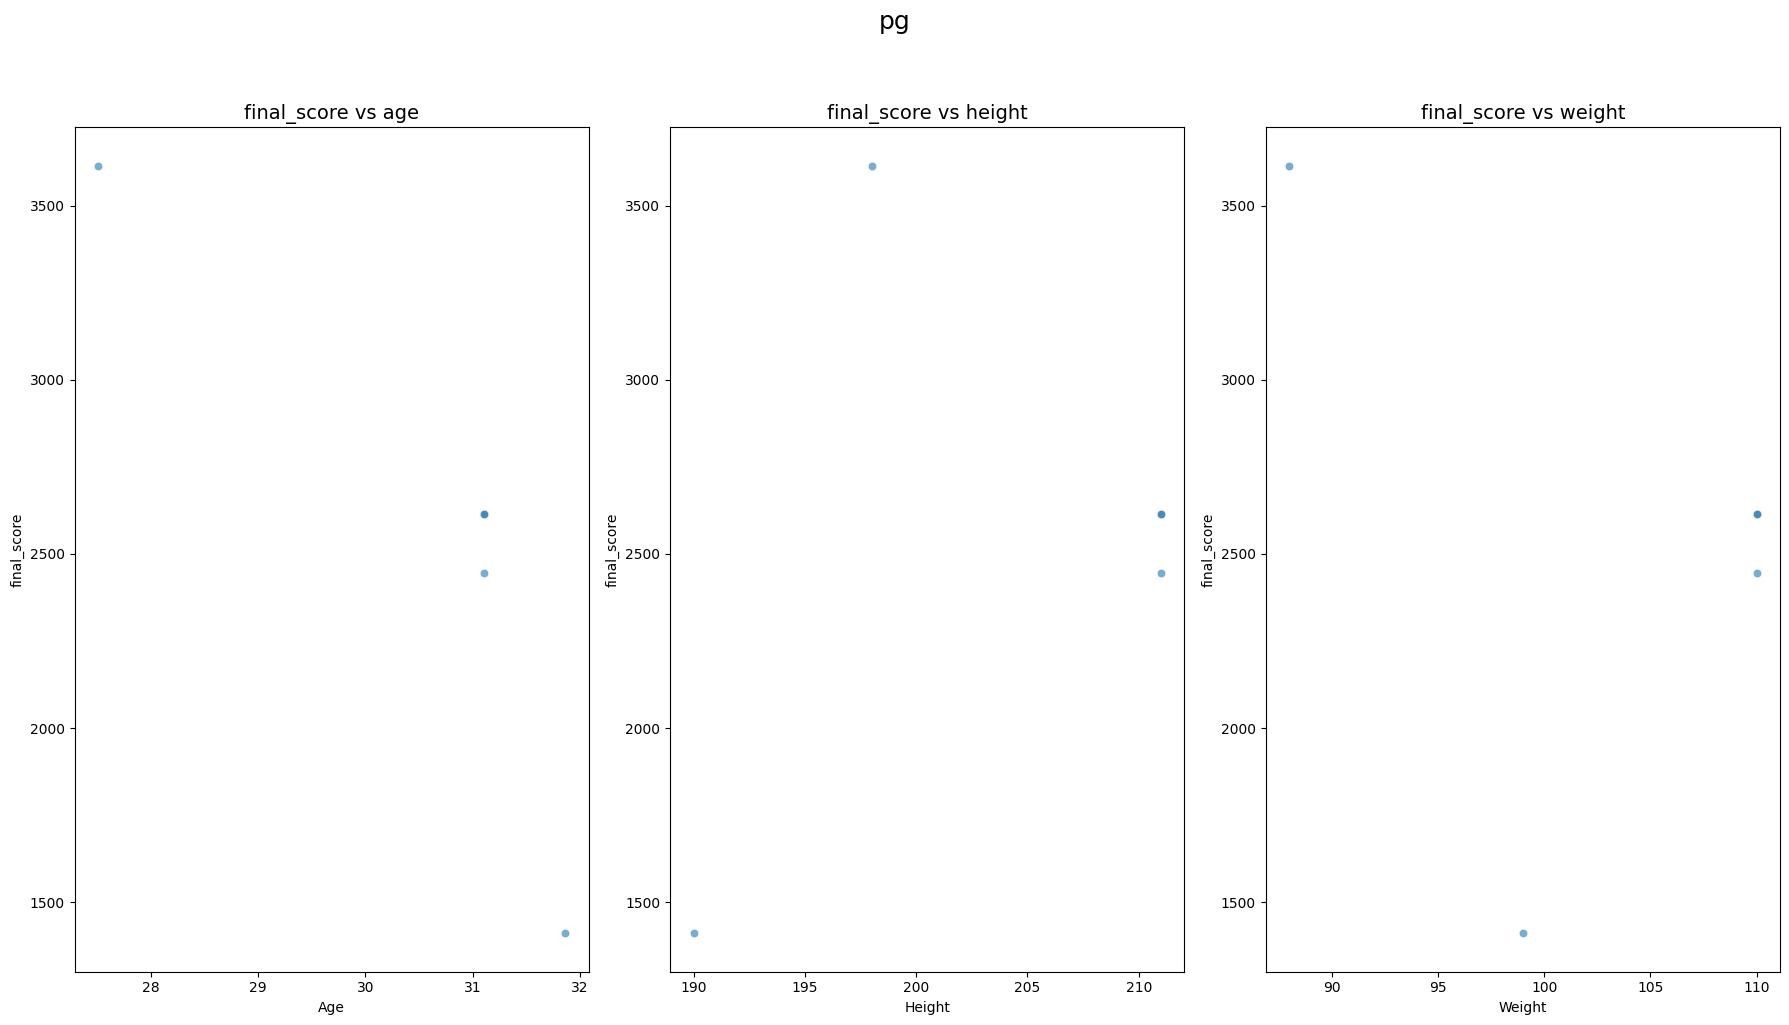

In [60]:
efficiency_metrics = [
    'final_score',
]
physical_features = ['age', 'height', 'weight']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, metric in enumerate(efficiency_metrics):
    for j, feature in enumerate(physical_features):
        ax_index = i * len(physical_features) + j
        sns.scatterplot(
            x=feature,
            y=metric,
            data=df,
            ax=axes[ax_index],
            alpha=0.6
        )
        axes[ax_index].set_title(f'{metric} vs {feature}', fontsize=14)
        axes[ax_index].set_xlabel(feature.capitalize())
        axes[ax_index].set_ylabel(metric)
plt.suptitle('pg', fontsize=18, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98])

In [61]:
df

,id,award_type,name,age,height,weight,season,pos,points_per_game,assists_per_game,win_shares,salary,pct_threeP_field_goals,final_score
0,s/smartma01,DPOY,Marcus Smart,31.863014,190,99,2021-22,Point Guard and Shooting Guard,12.1,5.9,5.6,13839285,0.331,1410.509801
1,a/antetgi01,DPOY,Giannis Antetokounmpo,31.109589,211,110,2019-20,"Power Forward, Small Forward, Point Guard, and...",29.5,5.6,11.1,25842697,0.304,2613.230659
2,a/antetgi01,MVP,Giannis Antetokounmpo,31.109589,211,110,2018-19,"Power Forward, Small Forward, Point Guard, and...",27.7,5.9,14.4,24157304,0.256,2445.216359
3,a/antetgi01,MVP,Giannis Antetokounmpo,31.109589,211,110,2019-20,"Power Forward, Small Forward, Point Guard, and...",29.5,5.6,11.1,25842697,0.304,2613.230659
4,g/gilgesh01,MVP,Shai Gilgeous-Alexander,27.509589,198,88,2024-25,Point Guard and Shooting Guard,32.7,6.4,16.7,35859950,0.375,3614.375959


First 3 players for pg

1. Shai Gilgeous-Alexander
2. James Harden
3. Giannis Antetokounmpo

<div dir=rtl>

## آزمون فرض

</div>

<div dir=rtl>

### توابع مورد نیاز برای آزمون فرض

</div>

In [62]:
def normality_check(group_1, group_2, alpha = 0.05):
    is_normal = False
    shapiro_group_1 = stats.shapiro(group_1)
    shapiro_group_2 = stats.shapiro(group_2)
    if shapiro_group_1.pvalue > alpha and shapiro_group_2.pvalue > alpha:
        is_normal = True
    return is_normal

In [63]:
def run_stats_test(group_1, group_2, alpha = 0.05):
    is_normal = normality_check(group_1, group_2)
    
    if is_normal:
        t_stat, p_val = stats.ttest_ind(group_1, group_2)
        print(f'Chosen Test: Ttest, t_stat: {t_stat:.03f}, p_val: {p_val:0.3f}')
    else:
        u_stat, p_val = stats.mannwhitneyu(group_1, group_2)
        print(f'Chosen Test: Mannwhitneyu, u_stat: {u_stat:0.3f}, p_val: {p_val:0.3f}')
    
    if p_val < alpha:
        print("Result: The difference is statistically significant.")
    else:
        print("Result: No statistically significant difference was found.")
        

<div dir=rtl>

### فرضیه اول

بررسی فرض افزایش چابکی ۲۰ بازیکن برتر هر فصل در طول دو فصل اخیر.
چابکی به صورت نسبت قد به وزن افراد تعریف می‌شود.

دیدیم که قد بازیکن‌های برتر فصل‌های اخیر تقریبا به شکل یکسان باقی مانده است، پس سوال در خصوص تغییر وزن‌ها است. ابتدا به شکل بصری و سپس از روش آماری بررسی می‌کنیم.

بررسی از روش بصری:

</div>

In [64]:
df_agility = df_top_players.join(df_players, how='inner')[['height', 'weight', 'season']]
df_agility['agility'] = df_agility['height'] / df_agility['weight']
df_agility = df_agility.sort_values(by='agility', ascending=False)

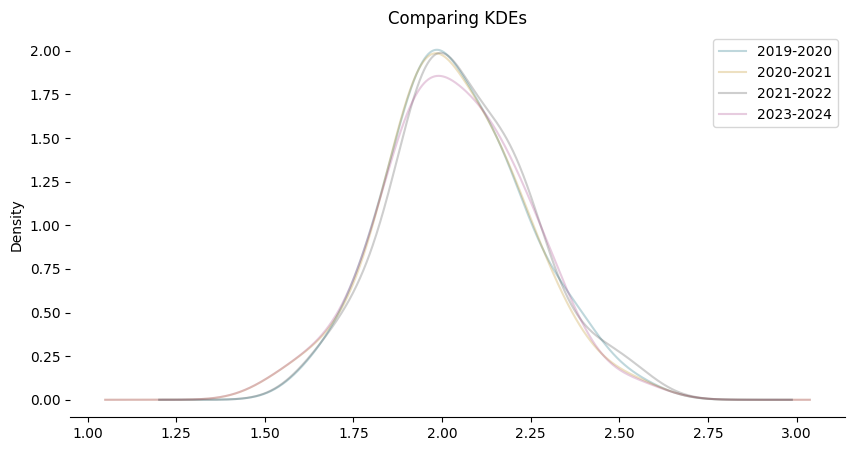

In [65]:
compare_kdes(
    data=[df_agility[df_agility['season'] == s]['agility'] for s in seasons],
    labels = list(seasons)
)

<div dir=rtl>

به نظر می‌رسد که از نظر ظاهری چابکی تفاوتی نداشته، اما باید از روش آماری بررسی کنیم:

</div>

<div dir=rtl>

#### آزمون فرض سوال اول

فرض صفر را به این شکل در نظر می‌گیریم:

میانگین چابکی در طول زمان بیشتر نشده است.

پس اگر این فرض رد شود می‌توانیم بگوییم که شواهدی علیه بیشتر شدن میانگین چابکی نداریم.

</div>

In [66]:

top20_2022_24 = pd.read_sql('''
                 SELECT pe.season, p.id, p.name, p.weight, p.height, pe.rank
                 FROM player_evaluations pe
                 JOIN players p on pe.player_id = p.id
                 WHERE (season = "2023-2024" OR season = "2022-2023") AND rank <=20;
                 ''', conn)

top20_2022_24['height_to_weight'] = top20_2022_24['height'] / top20_2022_24['weight']
# top20_2022_24
print(top20_2022_24['height_to_weight'].mean())
print(top20_2022_24['height_to_weight'].std())


2.0317745670445495
0.2042781892499472


In [67]:

top20_2020_22 = pd.read_sql('''
                 SELECT pe.season, p.id, p.name, p.weight, p.height, pe.rank
                 FROM player_evaluations pe
                 JOIN players p on pe.player_id = p.id
                 WHERE (season = "2020-2021" OR season = "2021-2022") AND rank <=20;
                 ''', conn)

top20_2020_22['height_to_weight'] = top20_2020_22['height'] / top20_2020_22['weight']
# top20_2020_22
print(top20_2020_22['height_to_weight'].mean())
print(top20_2020_22['height_to_weight'].std())

2.035052863804237
0.24648688382153908


### Check Normality

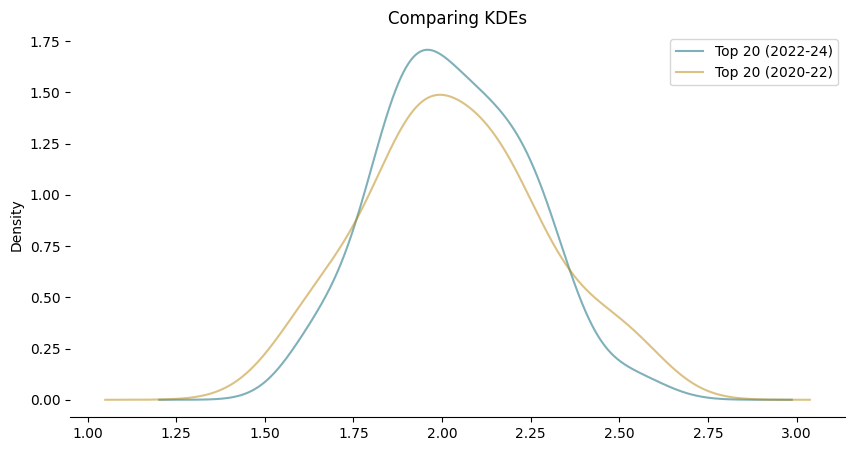

In [68]:
compare_kdes([top20_2022_24['height_to_weight'], top20_2020_22['height_to_weight']], labels=["Top 20 (2022-24)", "Top 20 (2020-22)"])

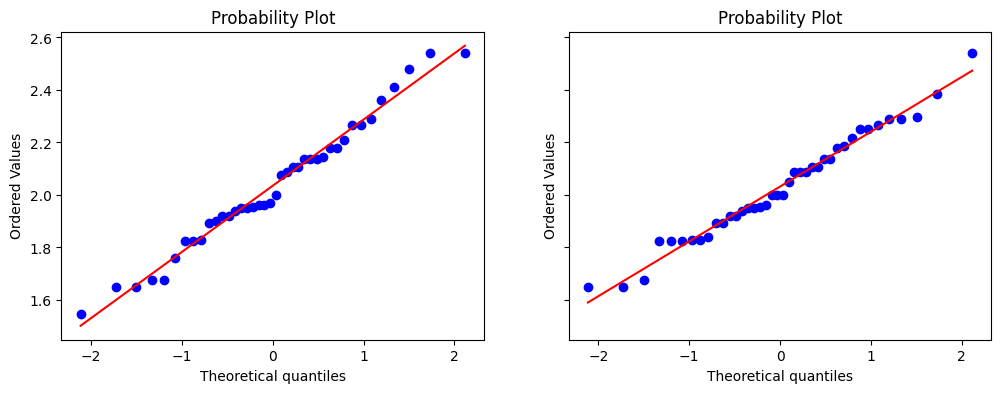

In [69]:
# QQPlot to test normality

qqplot([top20_2020_22['height_to_weight'], top20_2022_24['height_to_weight']])

In [70]:
normality_check(top20_2020_22['height_to_weight'], top20_2022_24['height_to_weight'])

True

<div dir="rtl">

توزیع نرمال است.

</div>

<div dir=rtl>

می‌خواهیم بررسی کنیم که چابکی ۲۰ بازیکن برتر هر فصل در دو فصل اخیر نسبت به 
دو فصل قبلی آن بیشتر شده است یا خیر.

به این منظور، فرض صفر را به این شکل تعریف می‌کنیم که:
چابکی ۲۰ بازیکن برتر هر فصل در دو فصل اخیر نسبت به 
دو فصل قبلی آن بیشتر نشده است.

بدین ترتیب اگر فرض صفر رد شود می‌توانیم بگوییم که شواهد علیه فرض جایگزین وجود ندارد و چابکی بیشتر شده است.

</div>

### Test the hypothesis

In [71]:
t_statistics, p_value = stats.ttest_ind(top20_2020_22['height_to_weight'], top20_2022_24['height_to_weight'], equal_var=False)

print(f'p_value = {p_value:.4f}')

p_value = 0.9485


In [72]:
run_stats_test(top20_2020_22['height_to_weight'], top20_2022_24['height_to_weight'])

Chosen Test: Ttest, t_stat: 0.065, p_val: 0.949
Result: No statistically significant difference was found.


<div dir=rtl>

### فرضیه دوم

</div>

<div dir=rtl>

می‌خواهیم بررسی کنیم که توانایی ذاتی بازیکن‌های تیم قهرمان در دو فصل اخیر نسبت به 
دو فصل قبلی آن بیشتر شده است یا خیر.

به این منظور، فرض صفر را به این شکل تعریف می‌کنیم که:
توانایی ذاتی بازیکن‌های تیم قهرمان در دو فصل اخیر نسبت به 
دو فصل قبلی آن بیشتر نشده است.

بدین ترتیب اگر فرض صفر رد شود می‌توانیم بگوییم که شواهد علیه فرض جایگزین وجود ندارد و توانایی ذاتی بیشتر شده است.

</div>

In [73]:
query = """
            SELECT 
                c.Season,
                c.Champion as team,
                p.id,
                p.age,
                p.career_length,
                (CAST(p.career_length AS FLOAT) / p.age) AS ability_metric
            FROM champions c
            JOIN roster_data r ON c.Season = r.season AND c.Champion = r.team_name
            JOIN players p ON r.player_id = p.id
            WHERE c.Season IN ('2024-25', '2023-24', '2022-23', '2021-22')
        """

df = pd.read_sql(query, conn)

recent_seasons = ['2024-25', '2023-24']
previous_seasons = ['2022-23', '2021-22']

recent_champs = df[df['Season'].isin(recent_seasons)]['ability_metric'].dropna()
previous_champs = df[df['Season'].isin(previous_seasons)]['ability_metric'].dropna()

In [74]:
normality_check(recent_champs, previous_champs)

False

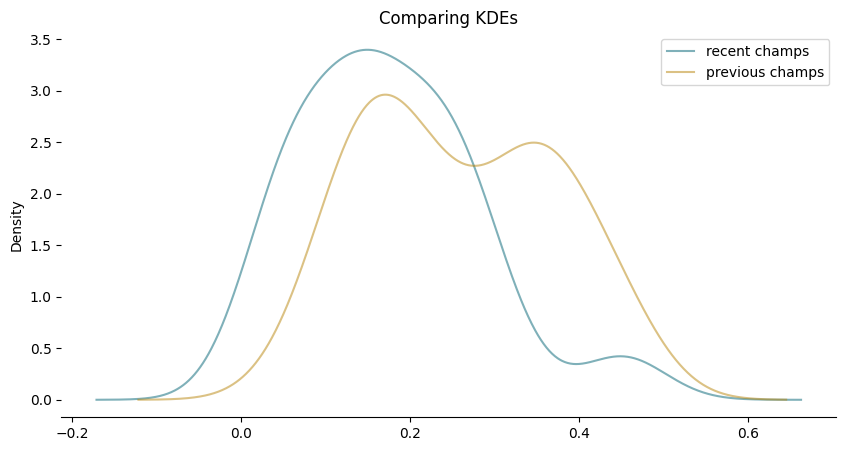

In [75]:
compare_kdes([recent_champs, previous_champs], labels=["recent champs", "previous champs"])

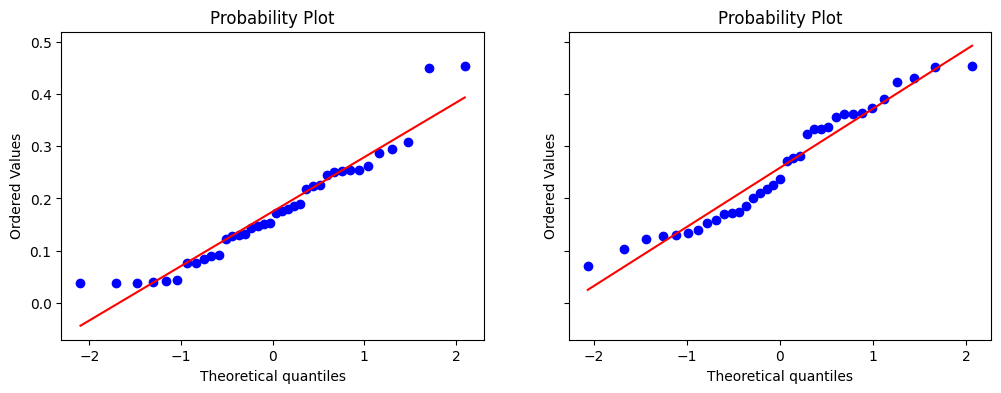

In [76]:
qqplot([recent_champs, previous_champs])

<div dir=rtl>

توزیع نرمال نیست و تابع آزمون به شکل خودکار از تست غیرپارامتری استفاده می‌کند.

</div>

In [77]:
run_stats_test(recent_champs, previous_champs)

Chosen Test: Mannwhitneyu, u_stat: 393.000, p_val: 0.003
Result: The difference is statistically significant.
